In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow

from dask.distributed import Client


In [2]:
client = Client(local_directory='/tmp', processes=False)
client

<Client: 'inproc://172.29.231.250/345/1' processes=1 threads=16, memory=15.49 GiB>

In [3]:
# run this cell to remove wet snow = -SI
from typing import Union

def id_wet_negative_si_test(dataset: xr.Dataset, inplace: bool = False) -> Union[None, xr.Dataset]:
    """
    Additional wet snow criteria if sd retrieval (snow-index since they are linear)
    becomes negative with snow cover is present we set pixel to wet.

    Args:
    dataset: xarray dataset with snow_index as data vars
    inplace: return copy of dataset or operate on dataset inplace?

    Returns:
    dataset: xarray data with wet_snow data var
    """
    # check inplace flag
    if not inplace:
        dataset = dataset.copy(deep=True)

    # check we have the neccessary variables
    necessary_vars = set(['snow_index', 'ims'])
    assert necessary_vars.issubset(set(dataset.data_vars)),\
          f"Missing variables {necessary_vars.difference(set(dataset.data_vars))}"

    # add alt_wet_flag to dataset if not already present    
    if 'alt_wet_flag' not in dataset.data_vars:
        dataset['alt_wet_flag'] = xr.zeros_like(dataset['deltaVV'])

    # identify wetting of snow by negative snow index with snow present
    #dataset['alt_wet_flag'] = dataset['alt_wet_flag'].where(((dataset['ims'] != 4) | (dataset['snow_index'] > 0)), 1)

    if not inplace:
        return dataset

In [6]:
# %%time
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
a = 2.5
b = 0.2
c = 0.55

wet_snow_thresh = np.arange(6, -6.1, -0.1)
#wet_snow_thresh = np.arange(-4, -1, 1)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')

    if Path(f'rmse_out_with_si/{ds_name}_wet_flag.nc').is_file():
        print('This file already exists, continuing.')
        continue
    
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    valid_pixels = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    
    # Brute-force loop
    for wst in wet_snow_thresh:
        print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
        ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
        ds = calc_delta_gamma(ds, B=b, inplace=False)
        
        ds = clip_delta_gamma_outlier(ds,thresh=8) # adjusted thresh from 3 to 8
        ds = calc_snow_index(ds)
        ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
        ds = id_newly_wet_snow(ds,wet_thresh=wst)
        ds = id_wet_negative_si(ds,wet_SI_thresh=0) #change to test depending on whether we want neg SI to flag as wet snow
        ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
        ds = flag_wet_snow(ds)
        # Compare snow depths - mask wet snow
        mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                ds['wet_snow'].sel(time=closest_ts).astype(bool))
        diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
        rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
        print(f'RMSE wet = {rmse_wet:0.2f}')
        rmse_wet_flag.loc[wst] = rmse_wet
        # Compare snow depths - no wet snow mask
        mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
        diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
        rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
        print(f'RMSE = {rmse:0.2f}')
        rmse_no_flag.loc[wst] = rmse
        valid_pixels.loc[wst] = mask_wet.sum() / mask.sum()
        print(f'Frac valid pixels = {mask_wet.sum() /mask.sum():0.2f}')

    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out_with_si/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out_with_si/{ds_name}_no_flag.nc')
    valid_pixels.to_netcdf(f'rmse_out_with_si/{ds_name}_valid_pixels.nc')
    

2023-06-28 06:55:25.210319  -- starting Banner_2020-02-18
This file already exists, continuing.
2023-06-28 06:55:25.212256  -- starting Banner_2021-03-15
This file already exists, continuing.
2023-06-28 06:55:25.212509  -- starting Cameron_2021-03-19
This file already exists, continuing.
2023-06-28 06:55:25.212739  -- starting Dry_Creek_2020-02-19
This file already exists, continuing.
2023-06-28 06:55:25.212828  -- starting Frasier_2020-02-11
This file already exists, continuing.
2023-06-28 06:55:25.212914  -- starting Frasier_2021-03-19
This file already exists, continuing.
2023-06-28 06:55:25.213027  -- starting Little_Cottonwood_2021-03-18
This file already exists, continuing.
2023-06-28 06:55:25.213130  -- starting Mores_2020-02-09
This file already exists, continuing.
2023-06-28 06:55:25.213274  -- starting Mores_2021-03-15
This file already exists, continuing.


In [66]:
with_neg_si_flag_wet_snow = True

directory = 'rmse_out_with_si'
#directory = 'rmse_out'

#if with_neg_si_flag_wet_snow == True:
#    directory = 'rmse_out_full_with_si'
#else:
#    directory = 'rmse_out_full'

results = sorted(glob(f'{directory}/*.nc'))
names = []
for f in results:
    if 'no_flag' in f:
        ds_name = f.split(f'{directory}/')[-1]
        ds_name = ds_name.split('_no')[0]
        names.append(ds_name)

thresh_results = pd.DataFrame(columns=names)
no_thresh_results = pd.DataFrame(columns=names)
valid_pixels_results = pd.DataFrame(columns=names)


for f in results:
    if 'wet_flag' in f:
        r = xr.open_dataarray(f).load()
        ds_name = f.split(f'{directory}/')[-1]
        ds_name = ds_name.split('_wet')[0]
        for ind,val in zip(r.wet_snow_thresh.values,r.values):
            thresh_results.loc[ind,ds_name] = val
    if 'no_flag' in f:
        r = xr.open_dataarray(f).load()
        ds_name = f.split(f'{directory}/')[-1]
        ds_name = ds_name.split('_no')[0]
        for ind,val in zip(r.wet_snow_thresh.values,r.values):
            no_thresh_results.loc[ind,ds_name] = val
    if 'valid' in f:
        r = xr.open_dataarray(f).load()
        ds_name = f.split(f'{directory}/')[-1]
        ds_name = ds_name.split('_valid')[0]
        for ind,val in zip(r.wet_snow_thresh.values,r.values):
            valid_pixels_results.loc[ind,ds_name] = val


<Axes: >

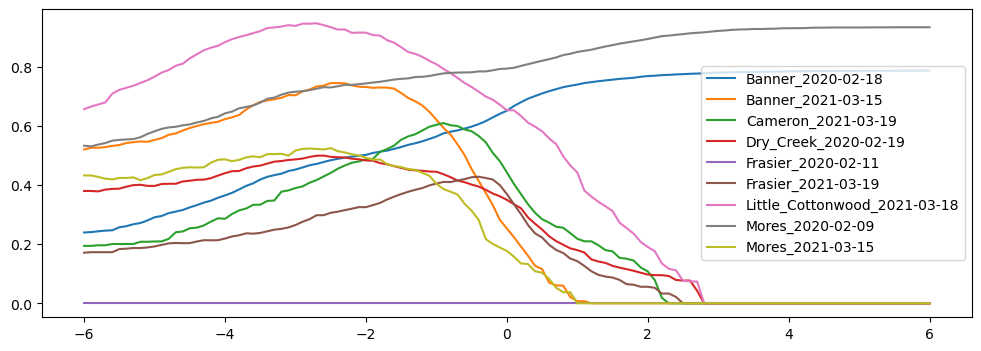

In [67]:
f,ax=plt.subplots(figsize=(12,4))
thresh_results.plot(ax=ax)

<Axes: >

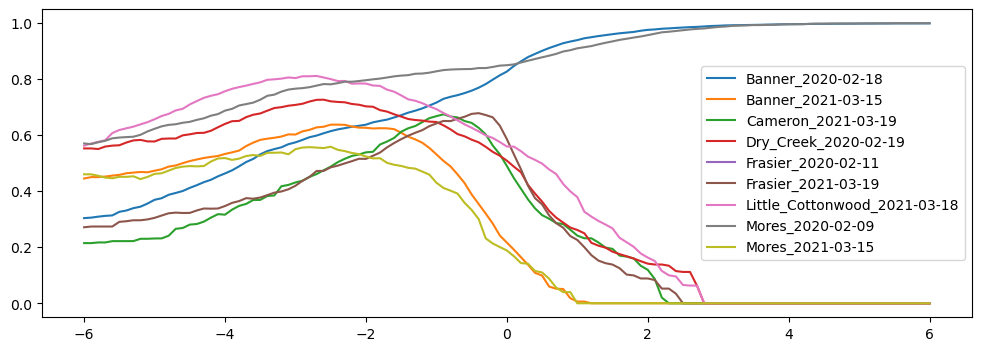

In [68]:
f,ax=plt.subplots(figsize=(12,4))
(thresh_results/no_thresh_results).plot(ax=ax)

<Axes: >

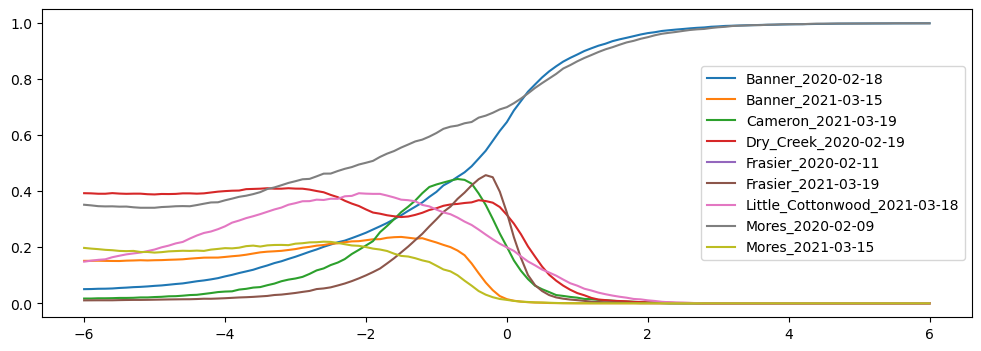

In [69]:
f,ax=plt.subplots(figsize=(12,4))
valid_pixels_results.plot(ax=ax)

In [50]:
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
A = np.array([2,2.5])
B = np.array([0.2,0.3,0.4,0.5])
C = np.array([0.4,0.45,0.5,0.55])

# Ross optimized params
#A = 2.5
#B = 0.2
#C = 0.55

# Lievens params
#A = 2
#B = 0.5
#C = 0.44

wet_snow_thresh = np.arange(-4, -1.1, 0.1)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')

    if Path(f'rmse_out_full_with_si/{ds_name}_wet_flag.nc').is_file():
        print('This file already exists, continuing.')
        continue

    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C),len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C,wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C), len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C, wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    valid_pixels = xr.DataArray(np.empty((len(A), len(B), len(C), len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C, wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    # Brute-force loop
    for a in A:
        for b in B:
            for c in C:
                for wst in wet_snow_thresh:
                    ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
                    ds = calc_delta_gamma(ds, B=b, inplace=False)
                    print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
                    ds = clip_delta_gamma_outlier(ds,thresh=8)
                    ds = calc_snow_index(ds)
                    ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
                    ds = id_newly_wet_snow(ds,wet_thresh=wst)
                    ds = id_wet_negative_si(ds) #change to test depdning on whether to remove neg SI = wet snow
                    ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
                    ds = flag_wet_snow(ds)
                    # Compare snow depths - mask wet snow
                    mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                            ds['wet_snow'].sel(time=closest_ts).astype(bool))
                    diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
                    rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
                    print(f'RMSE wet = {rmse_wet:0.2f}')
                    rmse_wet_flag.loc[a, b, c,wst] = rmse_wet
                    # Compare snow depths - no wet snow mask
                    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
                    diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
                    rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
                    print(f'RMSE = {rmse:0.2f}')
                    rmse_no_flag.loc[a,b,c,wst] = rmse
                    valid_pixels.loc[a,b,c,wst] = mask_wet.sum() / mask.sum()
                    print(f'Frac valid pixels = {mask_wet.sum()/ mask.sum():0.2f}')

    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out_full_with_si/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out_full_with_si/{ds_name}_no_flag.nc')
    valid_pixels.to_netcdf(f'rmse_out_full_with_si/{ds_name}_valid_pixels.nc')
    

2023-06-28 07:17:09.749754  -- starting Banner_2020-02-18
This file already exists, continuing.
2023-06-28 07:17:09.750021  -- starting Banner_2021-03-15
This file already exists, continuing.
2023-06-28 07:17:09.750182  -- starting Cameron_2021-03-19
This file already exists, continuing.
2023-06-28 07:17:09.750242  -- starting Dry_Creek_2020-02-19
This file already exists, continuing.
2023-06-28 07:17:09.750545  -- starting Frasier_2020-02-11
This file already exists, continuing.
2023-06-28 07:17:09.750630  -- starting Frasier_2021-03-19
This file already exists, continuing.
2023-06-28 07:17:09.750680  -- starting Little_Cottonwood_2021-03-18
This file already exists, continuing.
2023-06-28 07:17:09.750733  -- starting Mores_2020-02-09
This file already exists, continuing.
2023-06-28 07:17:09.750788  -- starting Mores_2021-03-15
This file already exists, continuing.


In [70]:
directory = 'rmse_out_full'
directory = 'rmse_out_full_with_si'

which_site = 5

results1 = sorted(glob(f'{directory}/*wet*.nc'))
results2 = sorted(glob(f'{directory}/*no*.nc'))
results3 = sorted(glob(f'{directory}/*valid*.nc'))

wet_snow = xr.open_dataarray(results1[which_site])
all_snow = xr.open_dataarray(results2[which_site])
frac_valid = xr.open_dataarray(results3[which_site])

all_rmse = xr.concat([wet_snow,all_snow],'wet_or_all')


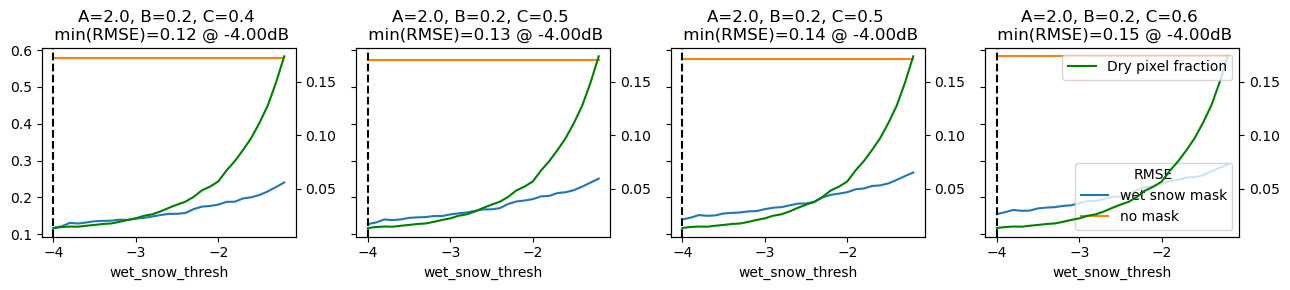

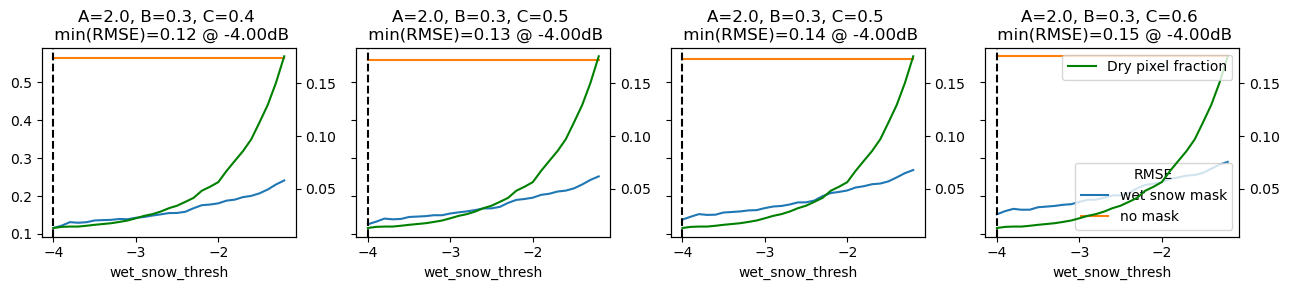

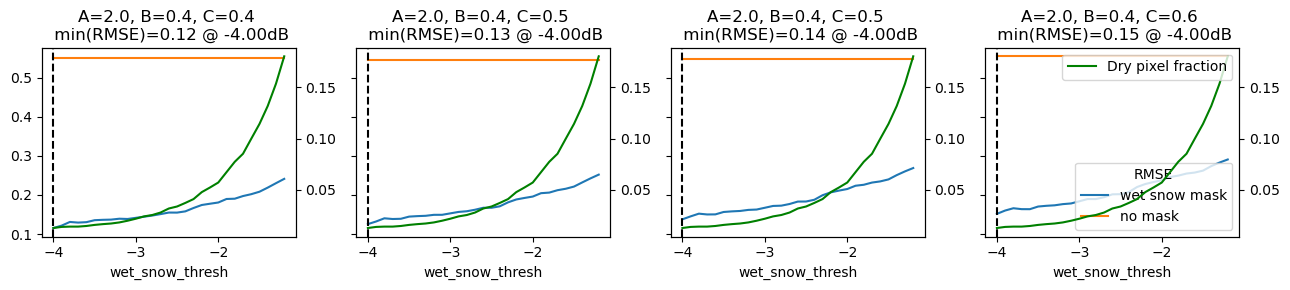

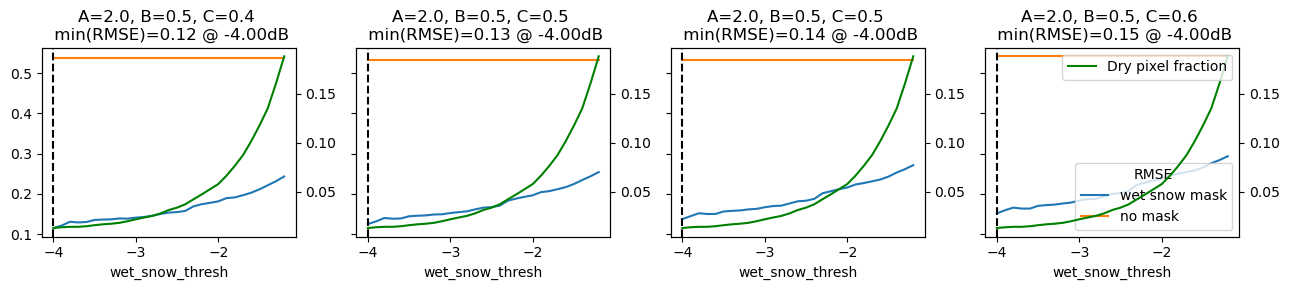

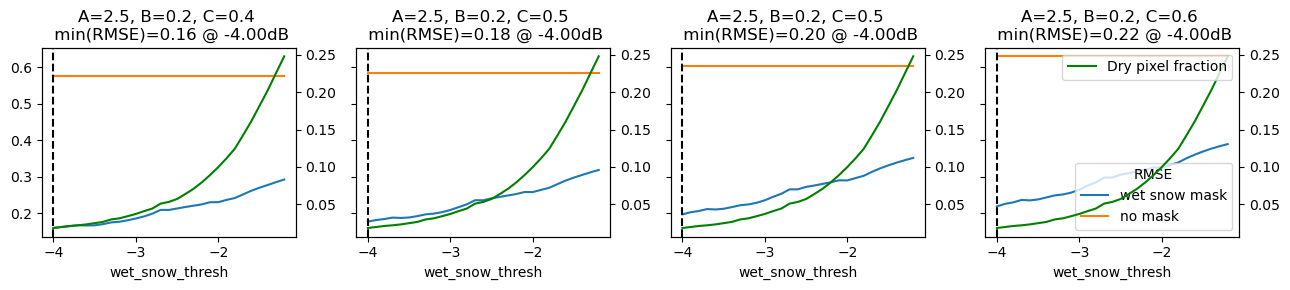

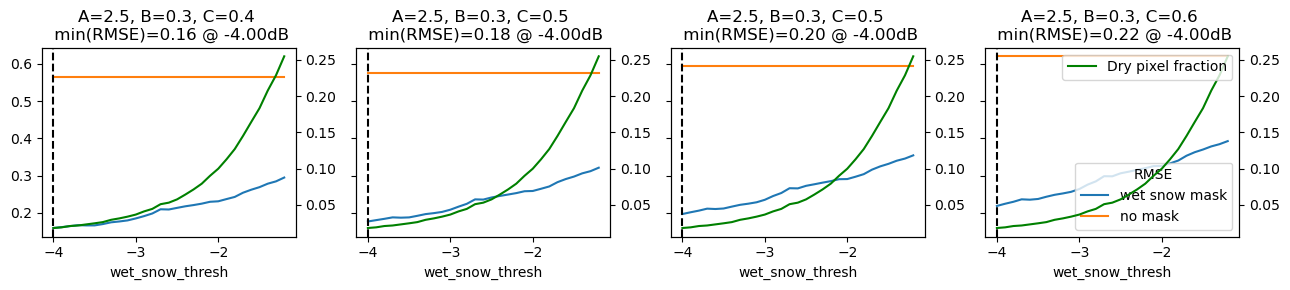

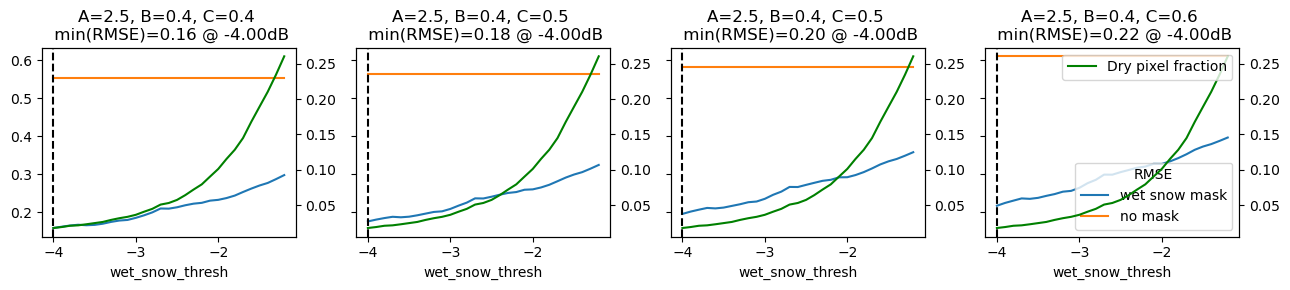

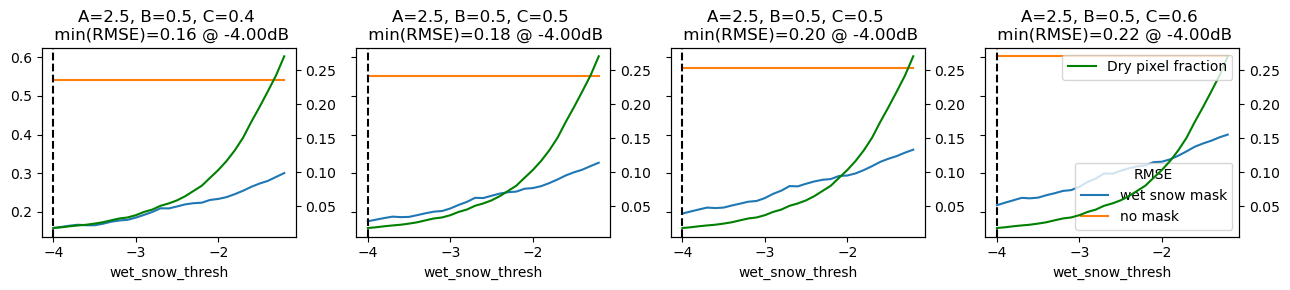

In [71]:
for a in A:
    for b in B:
        f = all_rmse.sel(A=a).sel(B=b).plot(hue='wet_or_all',col='C',add_legend=False)
        for c,ax in zip(C,f.axs[0]):
            frac_ax = ax.twinx()
            fv = frac_valid.sel(A=a).sel(B=b).sel(C=c).plot(ax=frac_ax,color='green',label='dry pixel fraction')
            frac_ax.set_title('')
            ax.axvline(wet_snow.sel(A=a).sel(B=b).sel(C=c).idxmin(),color='black',linestyle='--')
            ax.set_title(f'A={a:0.1f}, B={b:0.1f}, C={c:0.1f} \n min(RMSE)={float(wet_snow.sel(A=a).sel(B=b).sel(C=c).min()):0.2f} @ {float(wet_snow.sel(A=a).sel(B=b).sel(C=c).idxmin()):0.2f}dB')
        ax.legend(labels=['wet snow mask','no mask'], title= 'RMSE', loc='lower right')
        frac_ax.legend(handles=fv,labels=['Dry pixel fraction'], loc='upper right')
        plt.tight_layout()

In [ ]:
iles = sorted(glob('spicy_s1_stacks/*.nc'))


for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')

    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]

A=2.50; B=0.20; C=0.55; wst=-4.00
A=2.50; B=0.20; C=0.55; wst=-3.00
A=2.50; B=0.20; C=0.55; wst=-2.00
A=2.50; B=0.20; C=0.55; wst=-1.00
A=2.50; B=0.20; C=0.55; wst=0.00
A=2.50; B=0.20; C=0.55; wst=1.00
A=2.50; B=0.20; C=0.55; wst=2.00
A=2.50; B=0.20; C=0.55; wst=3.00
A=2.50; B=0.20; C=0.55; wst=4.00


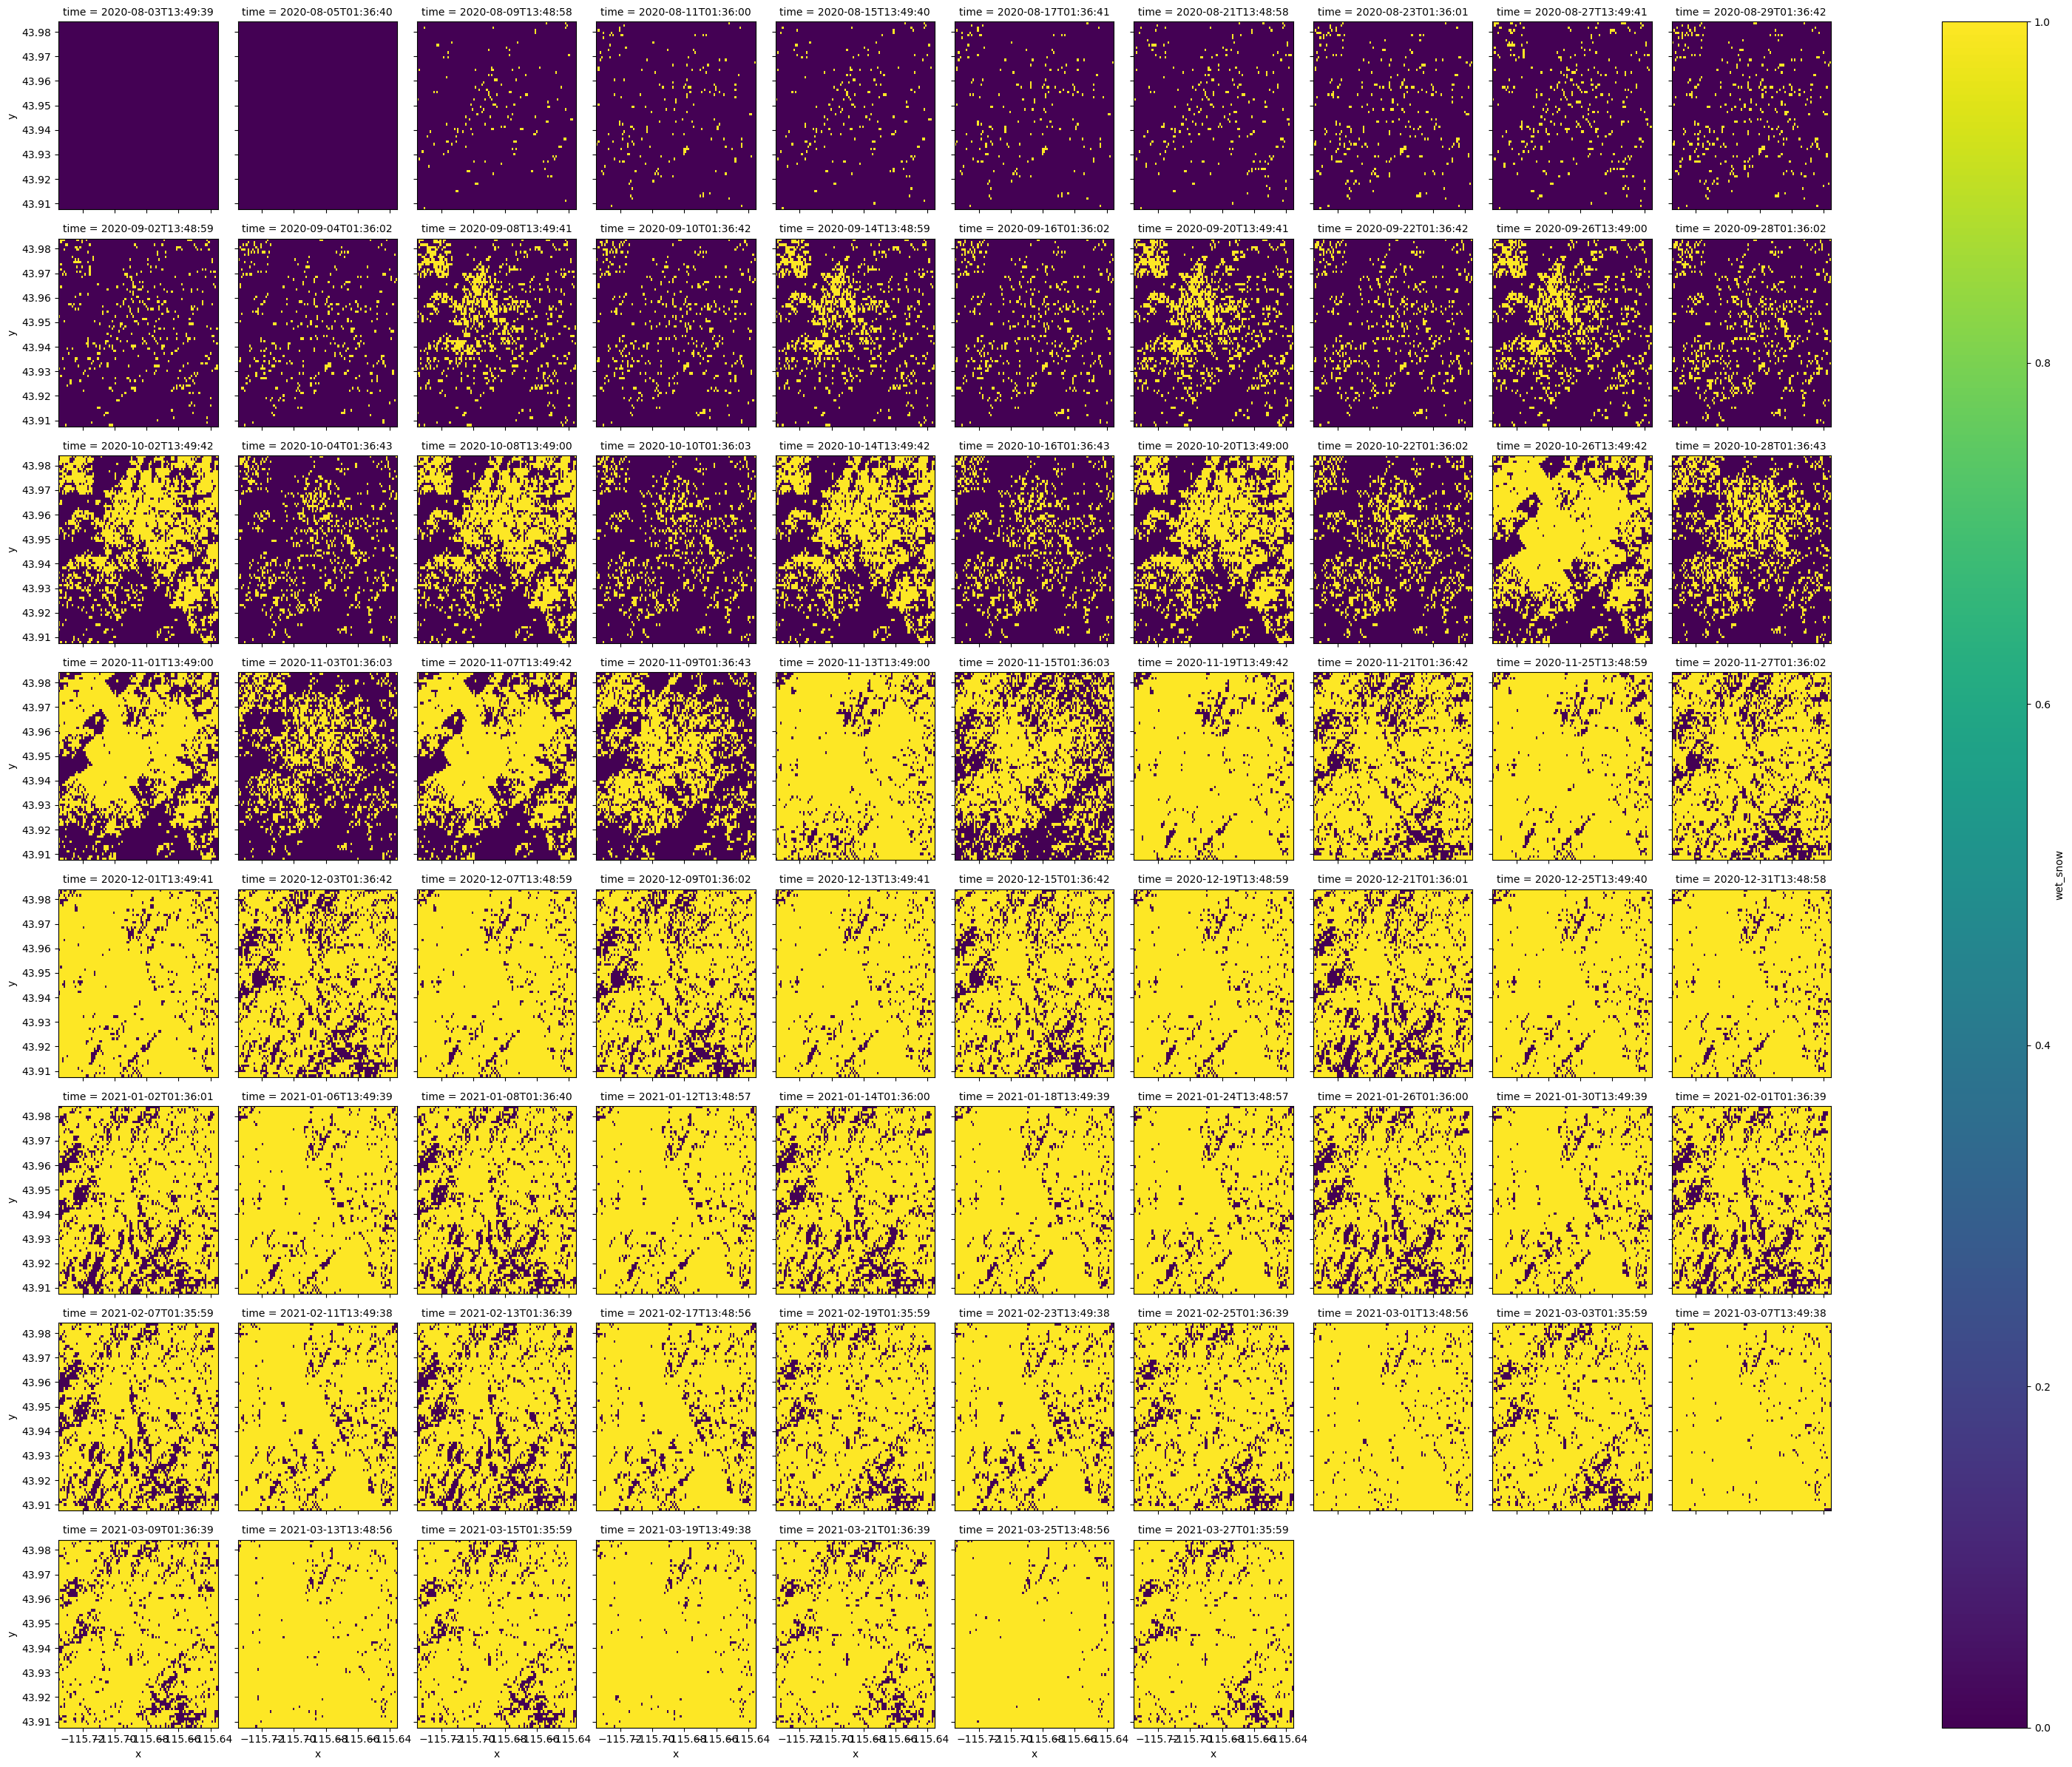

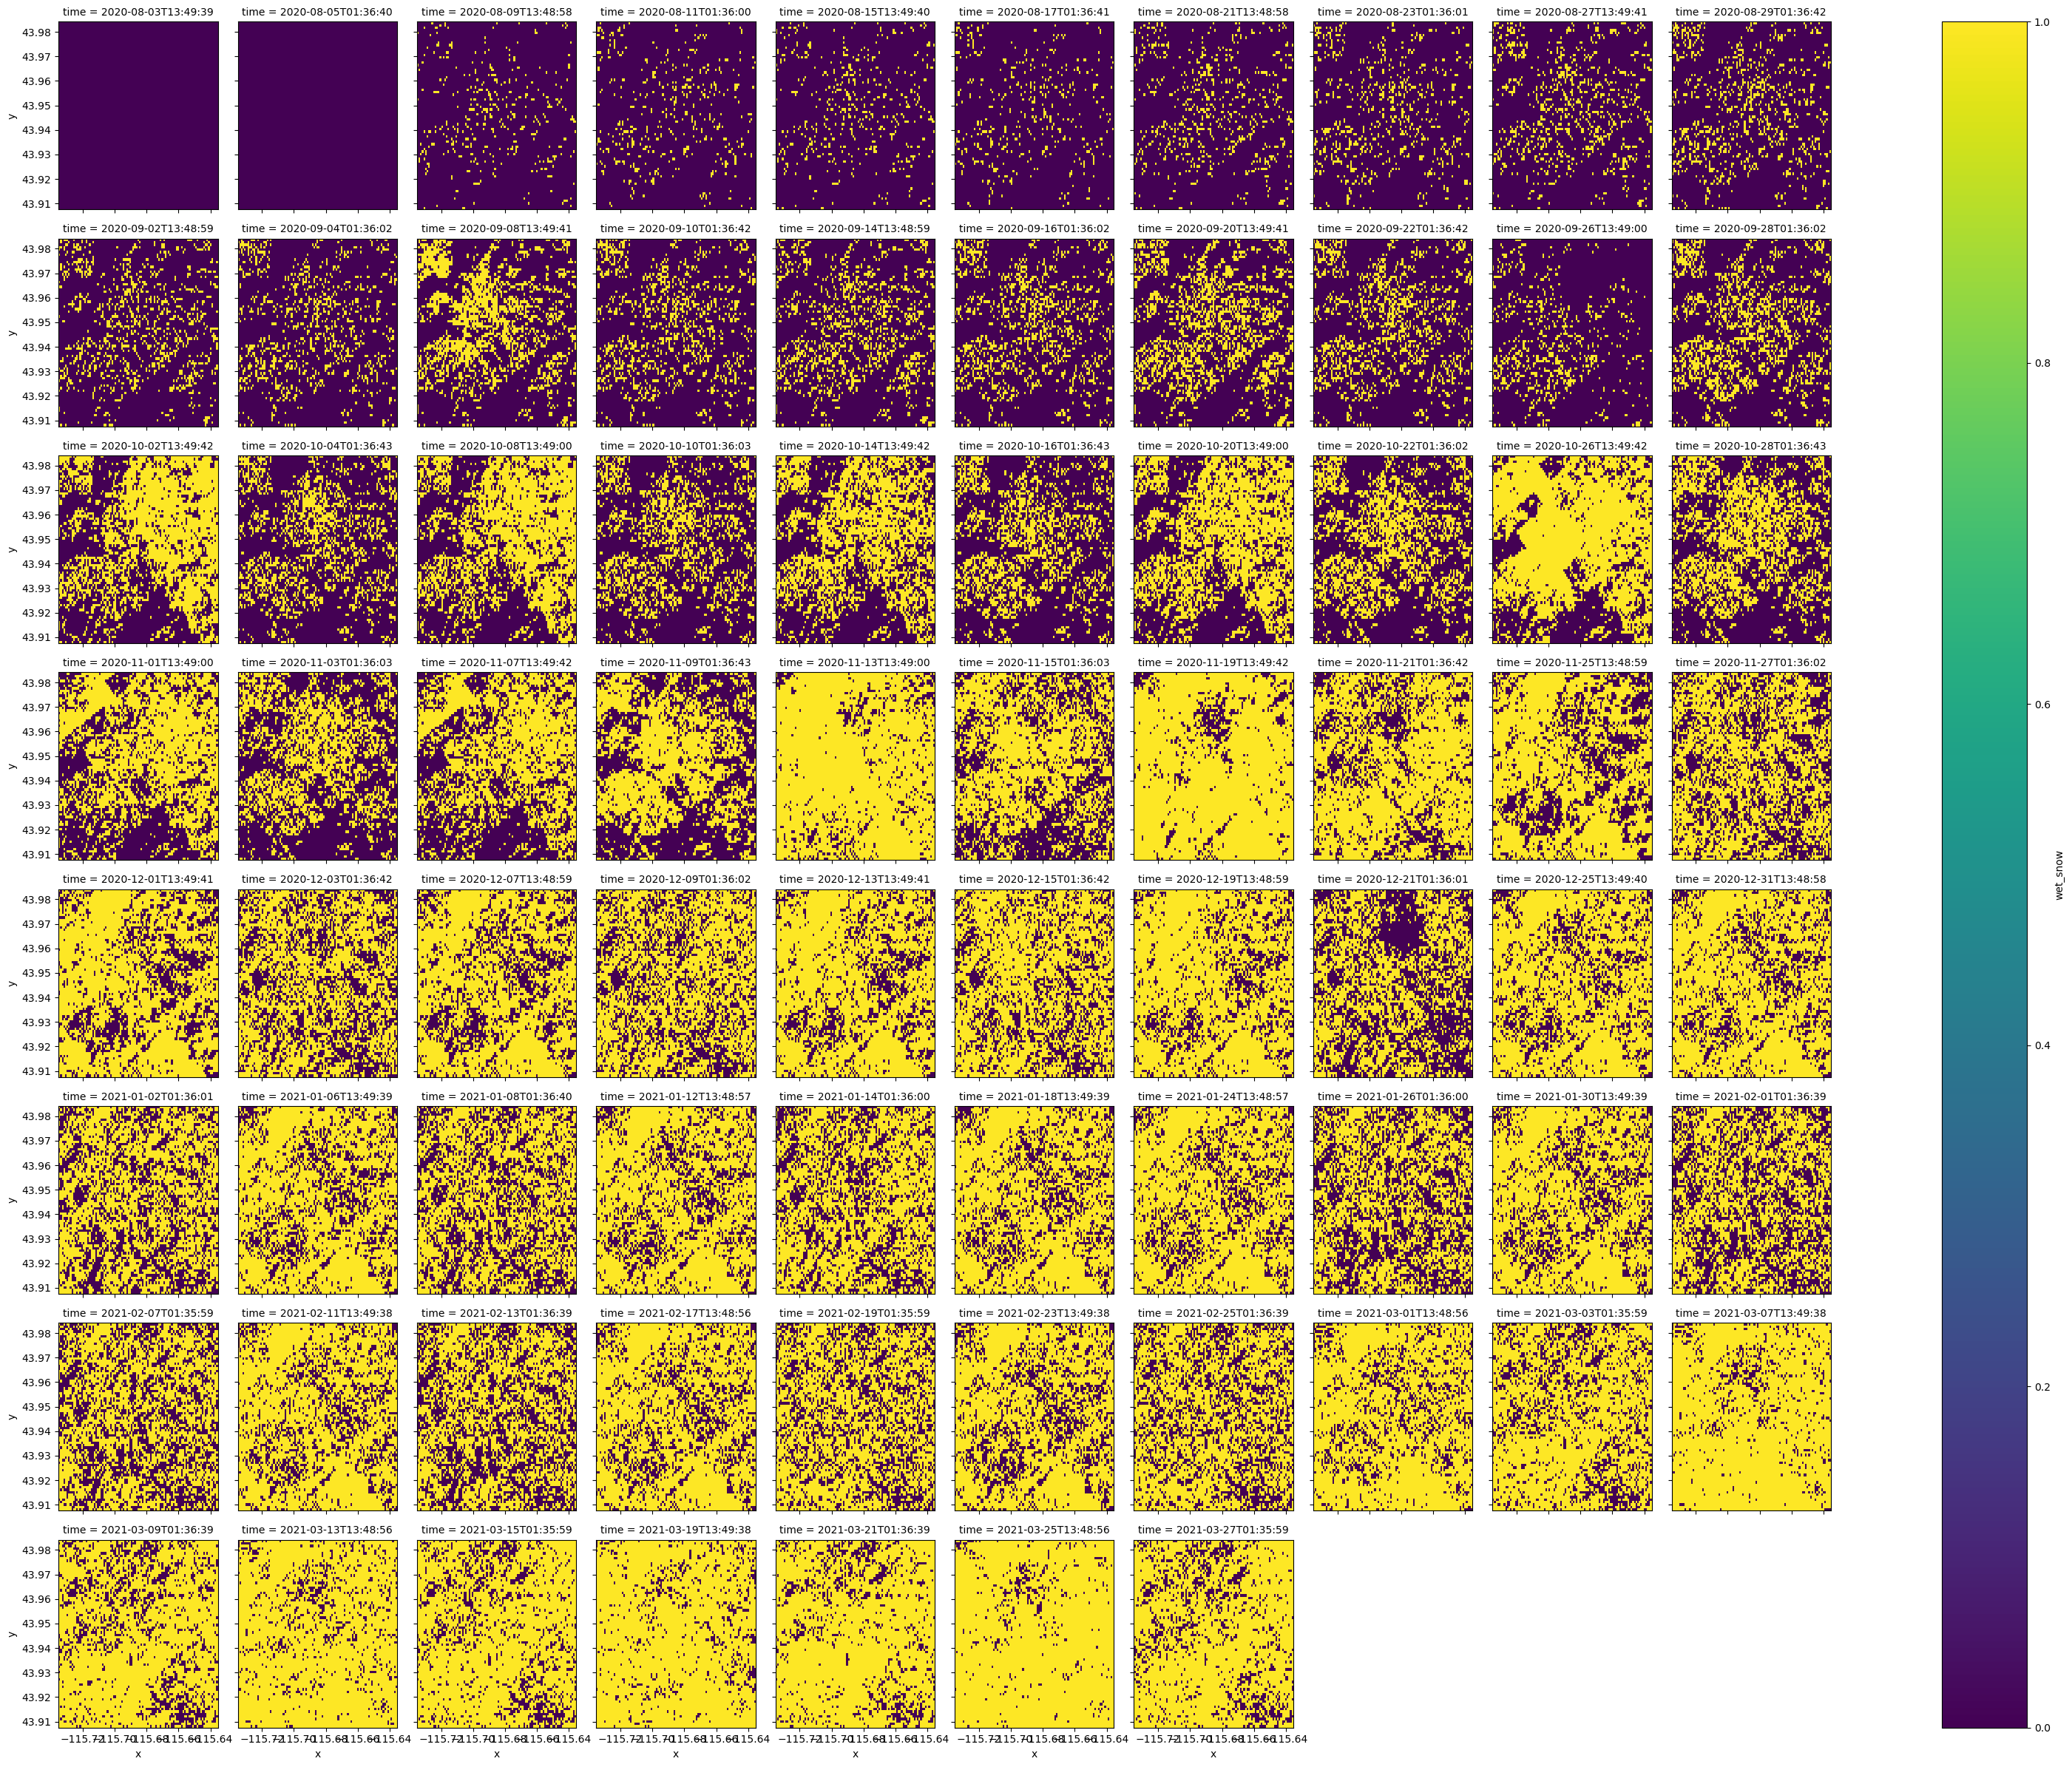

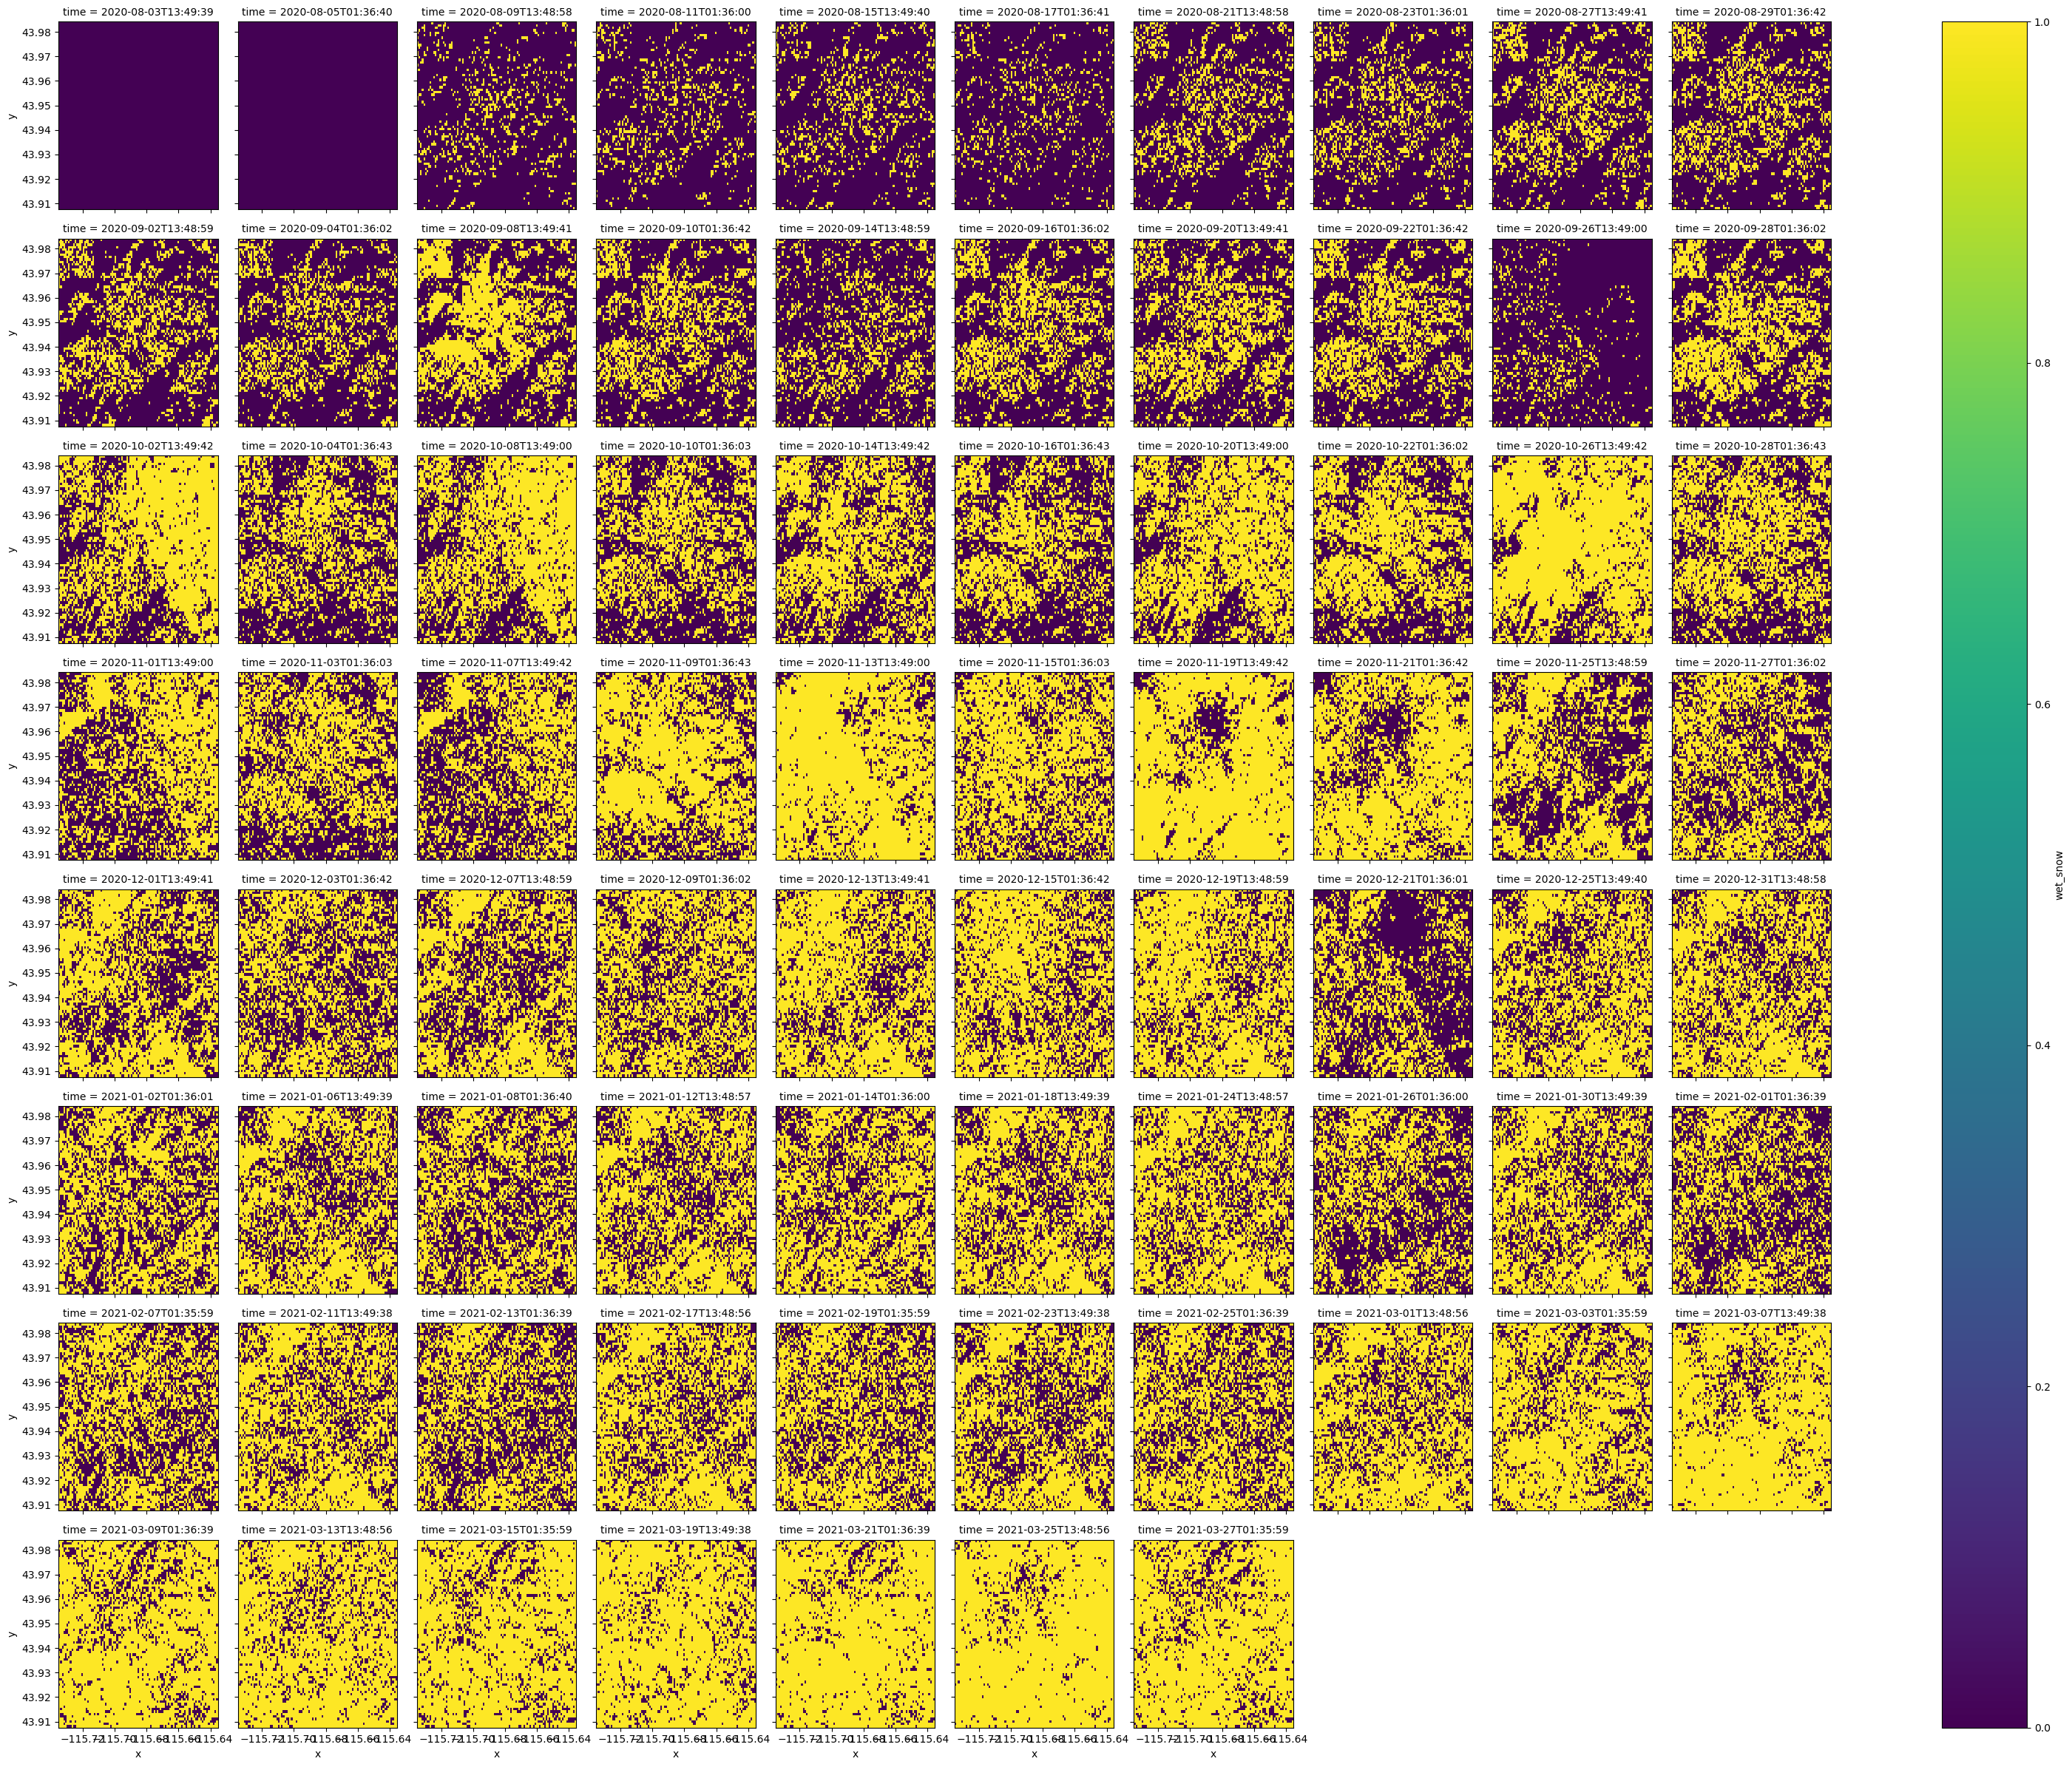

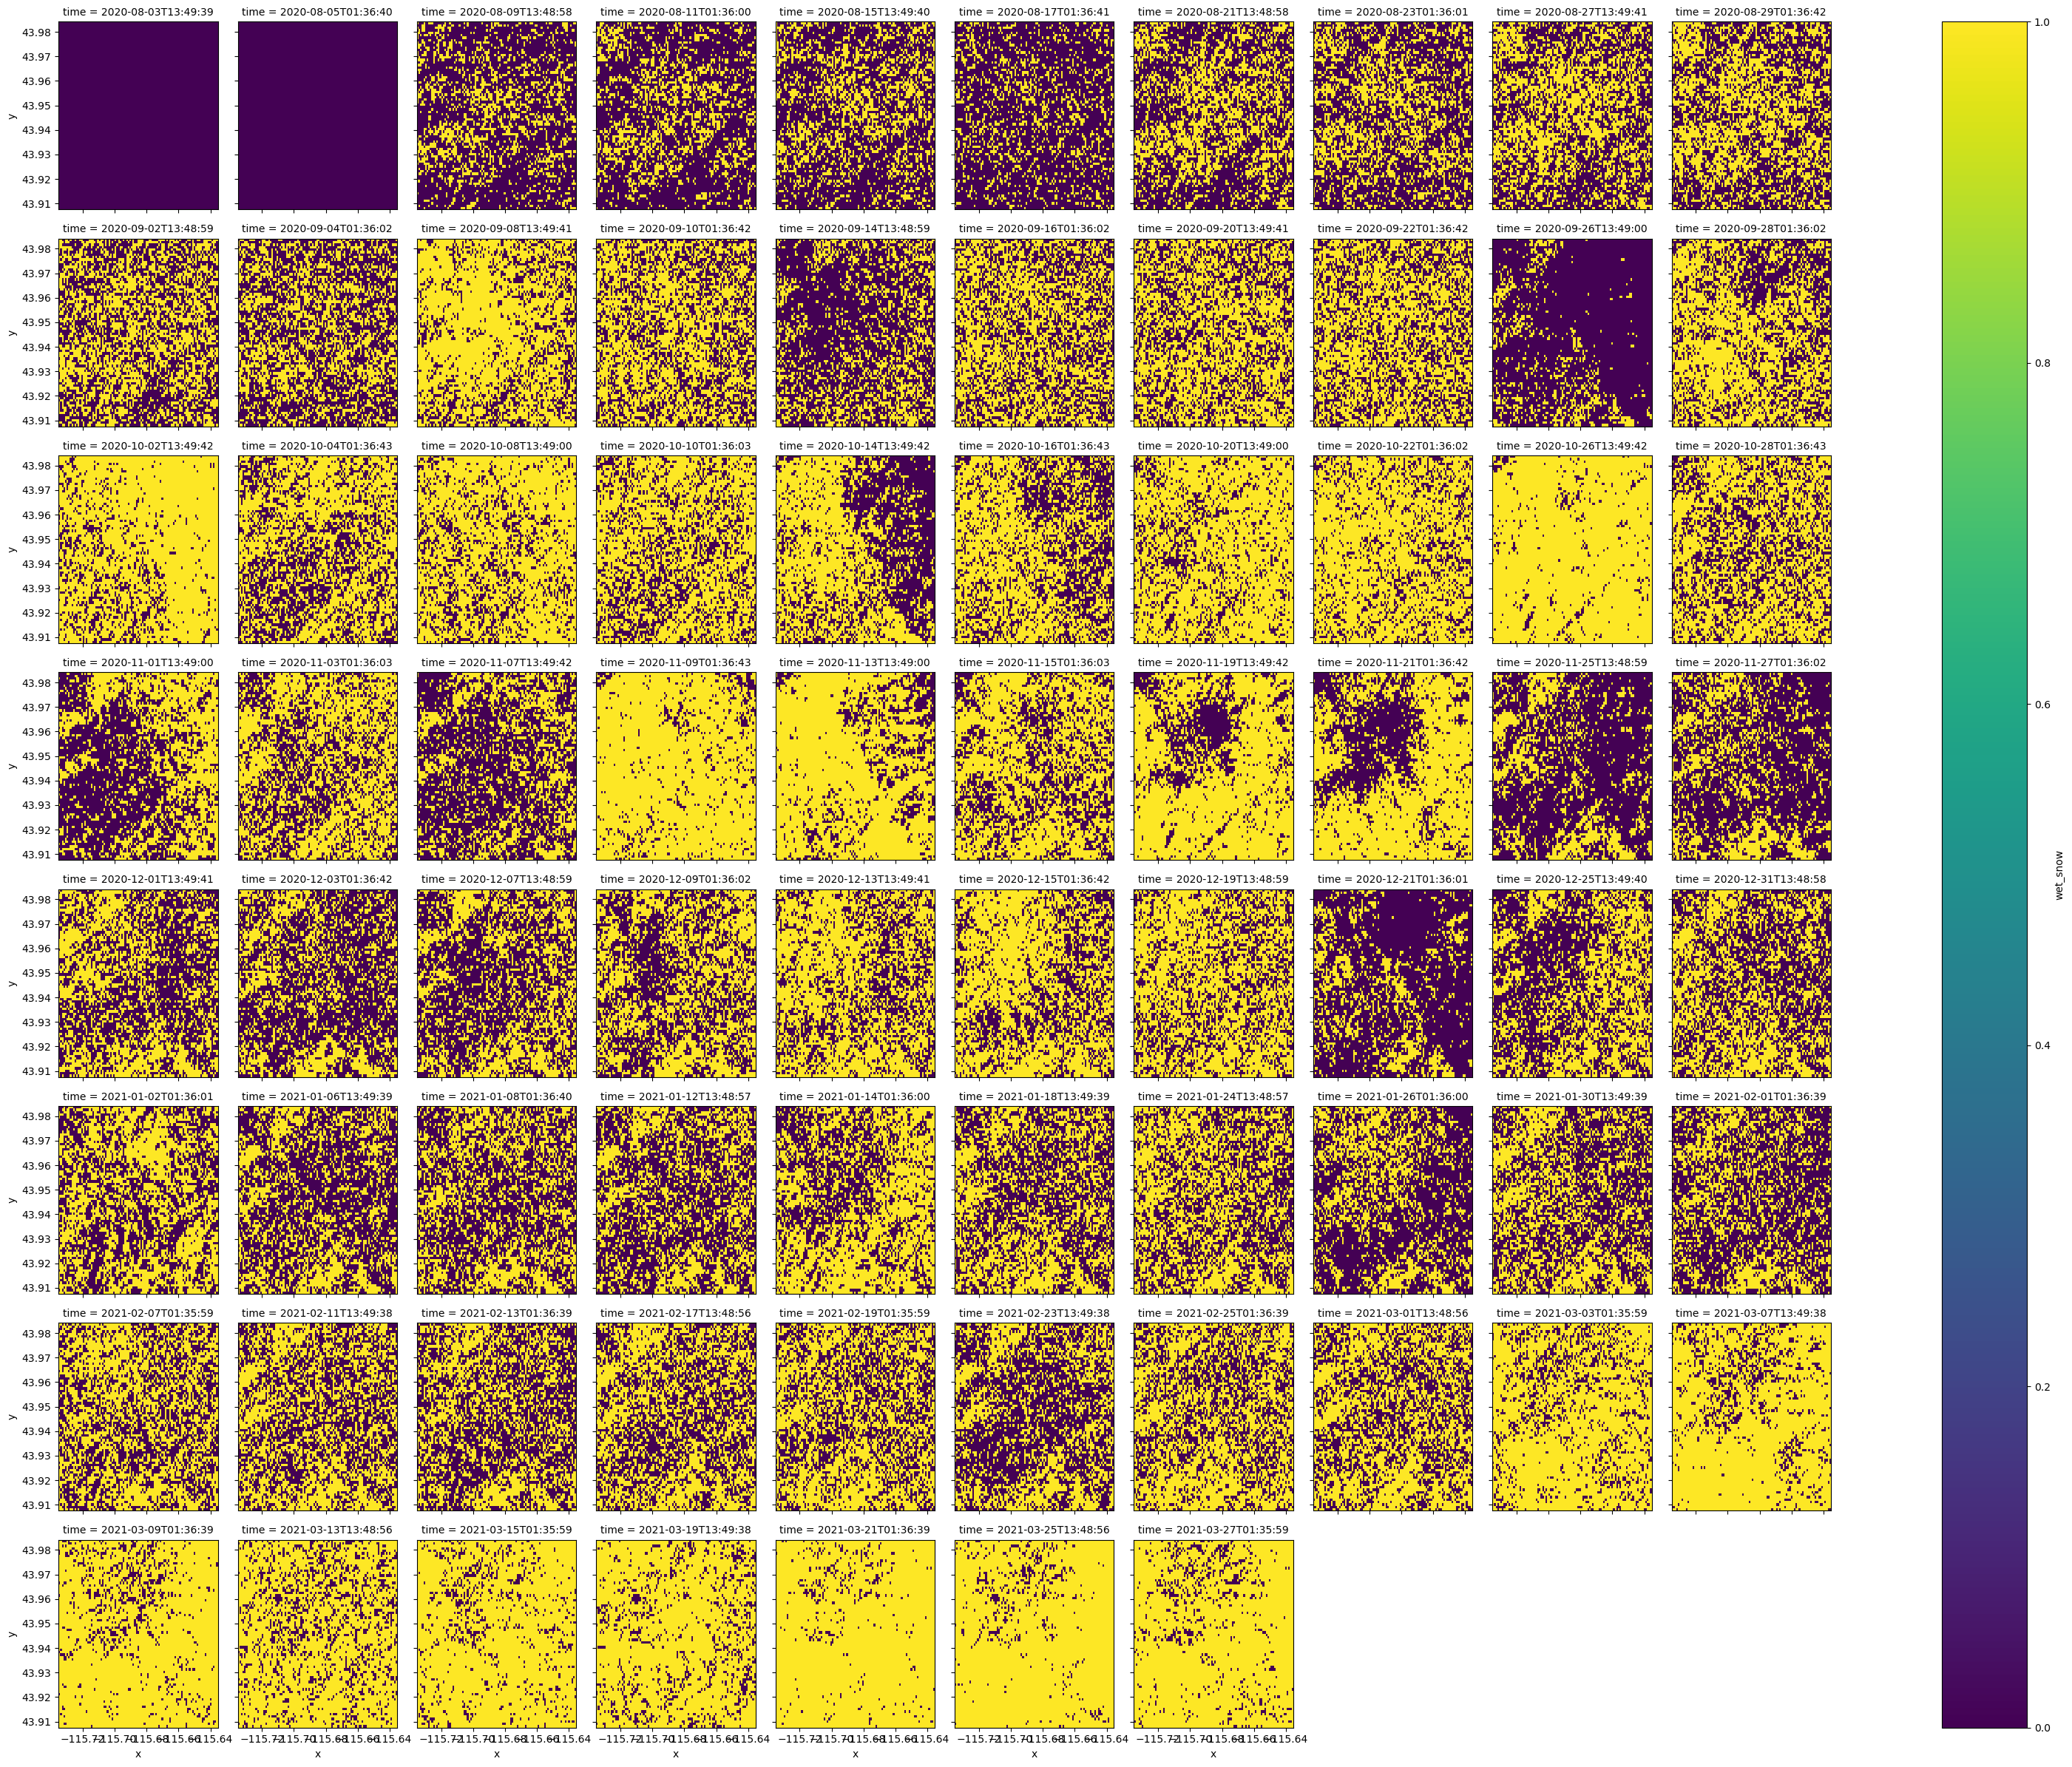

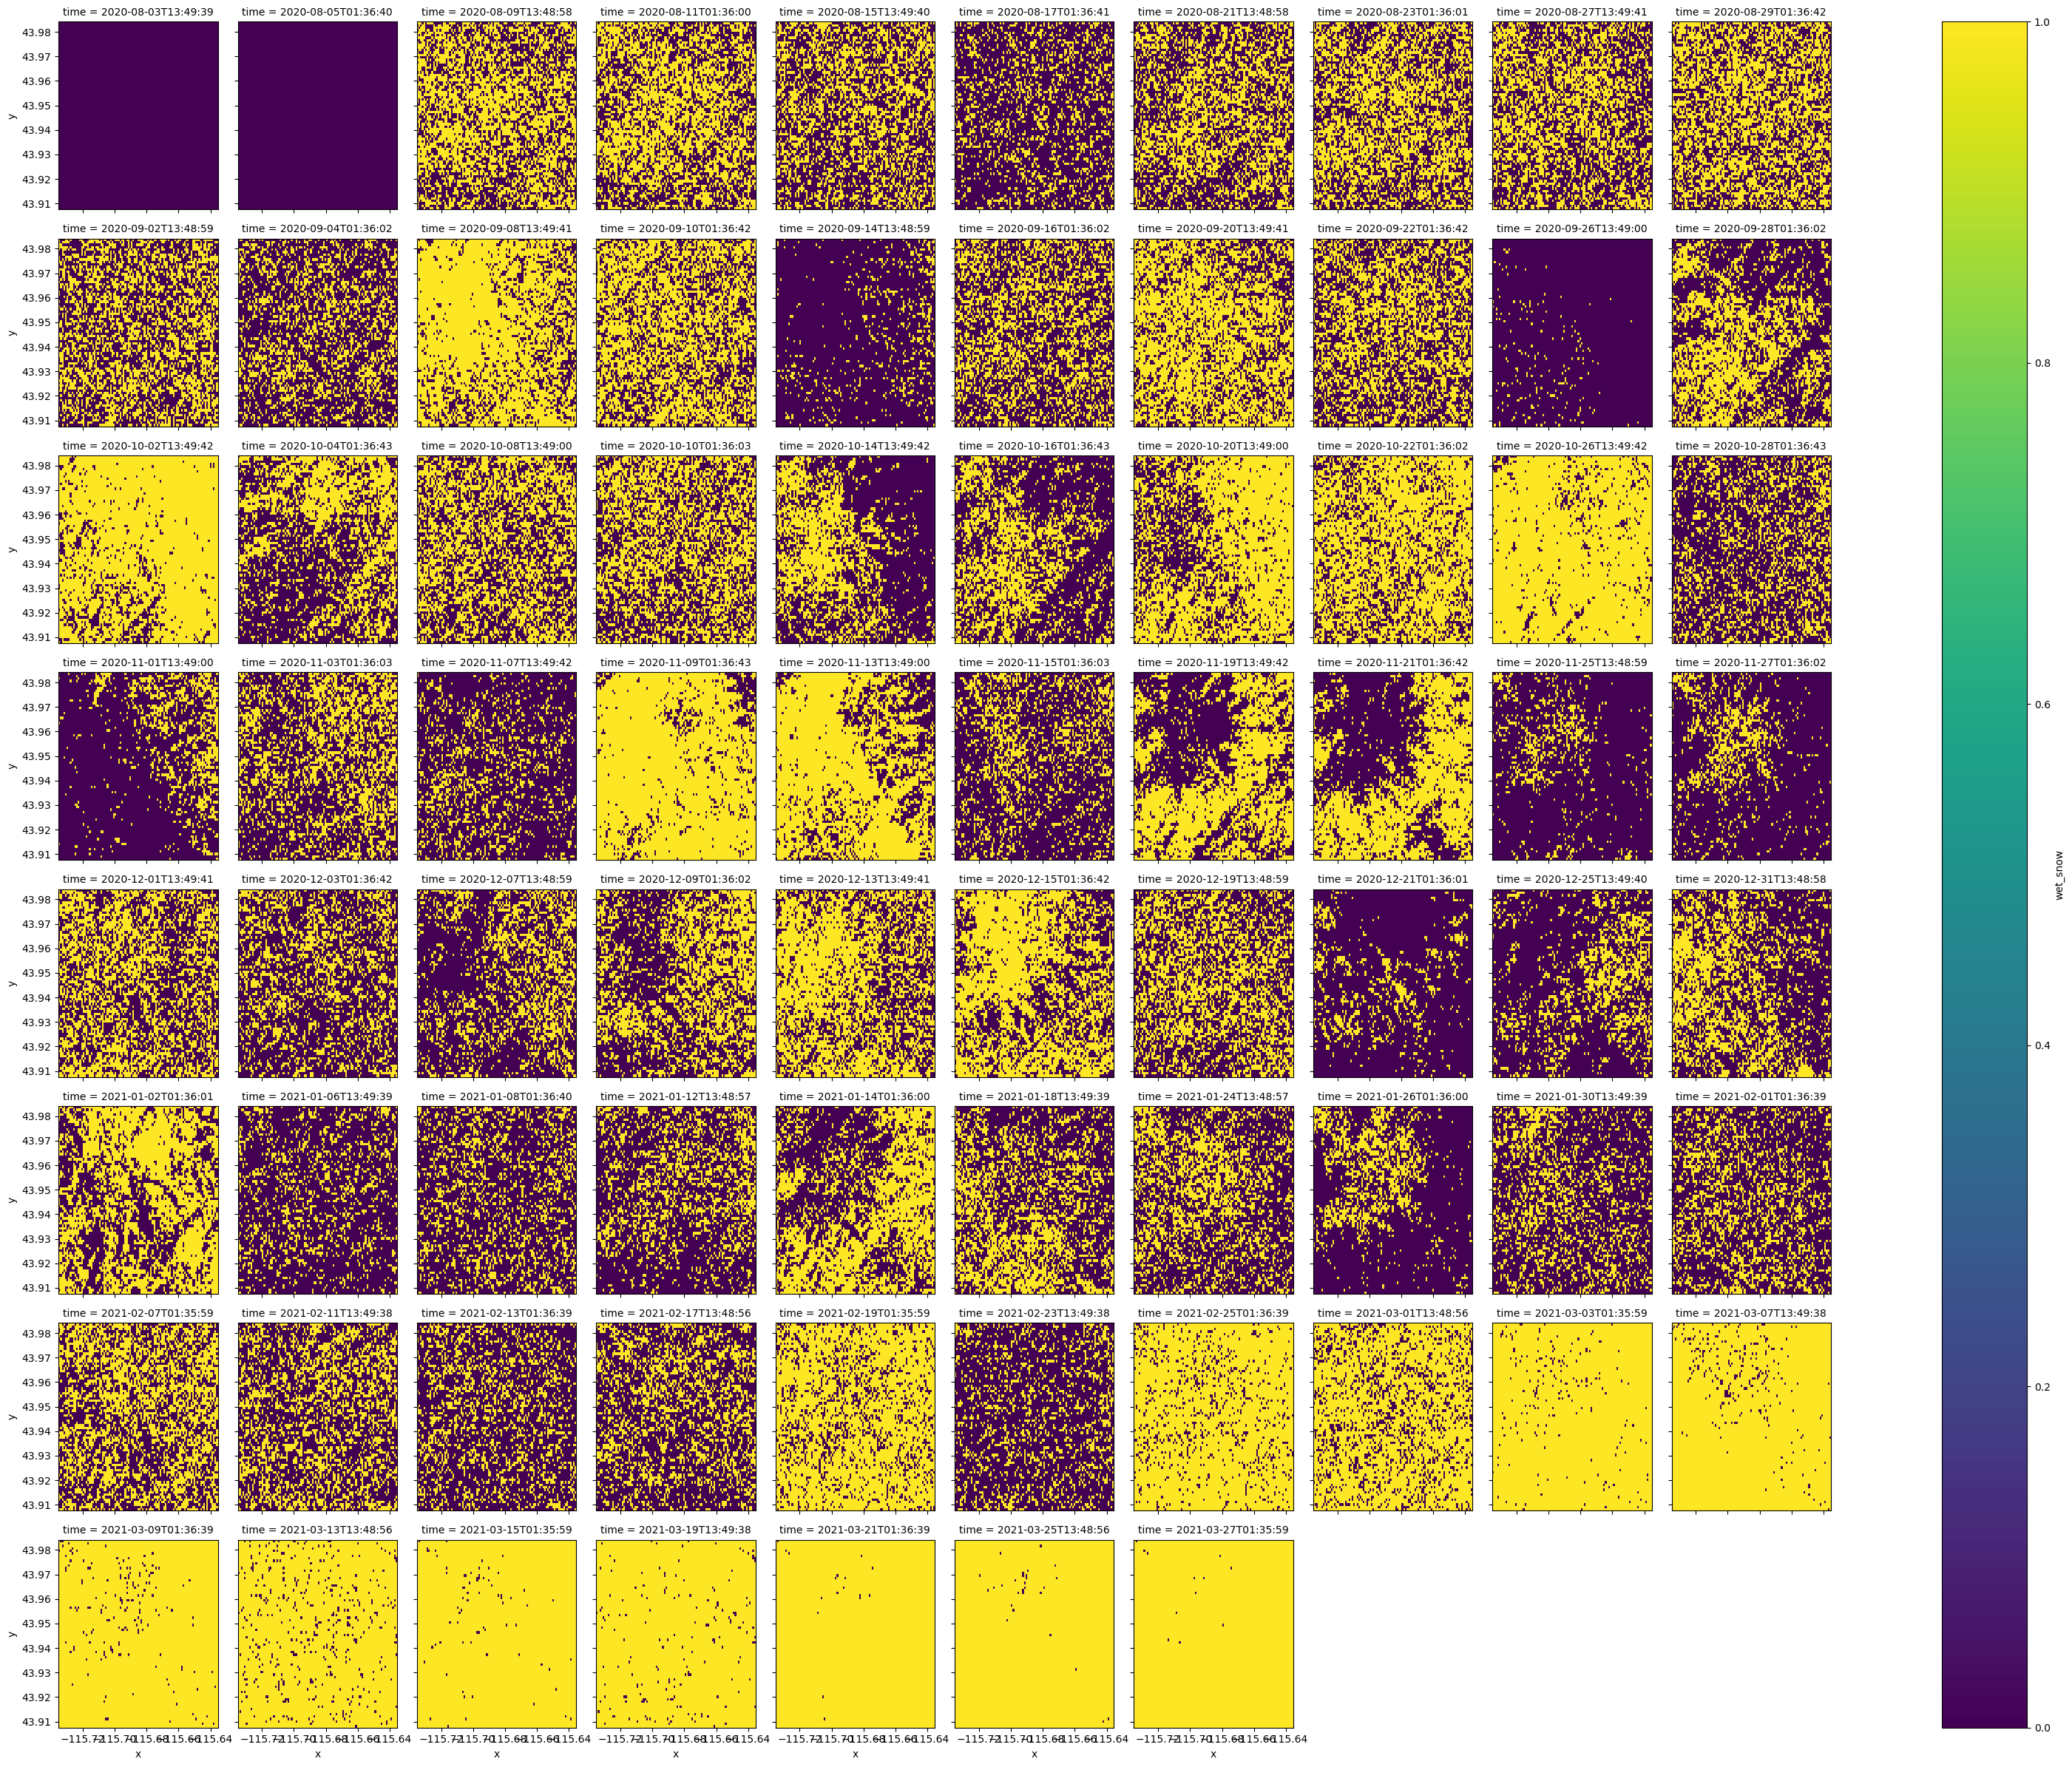

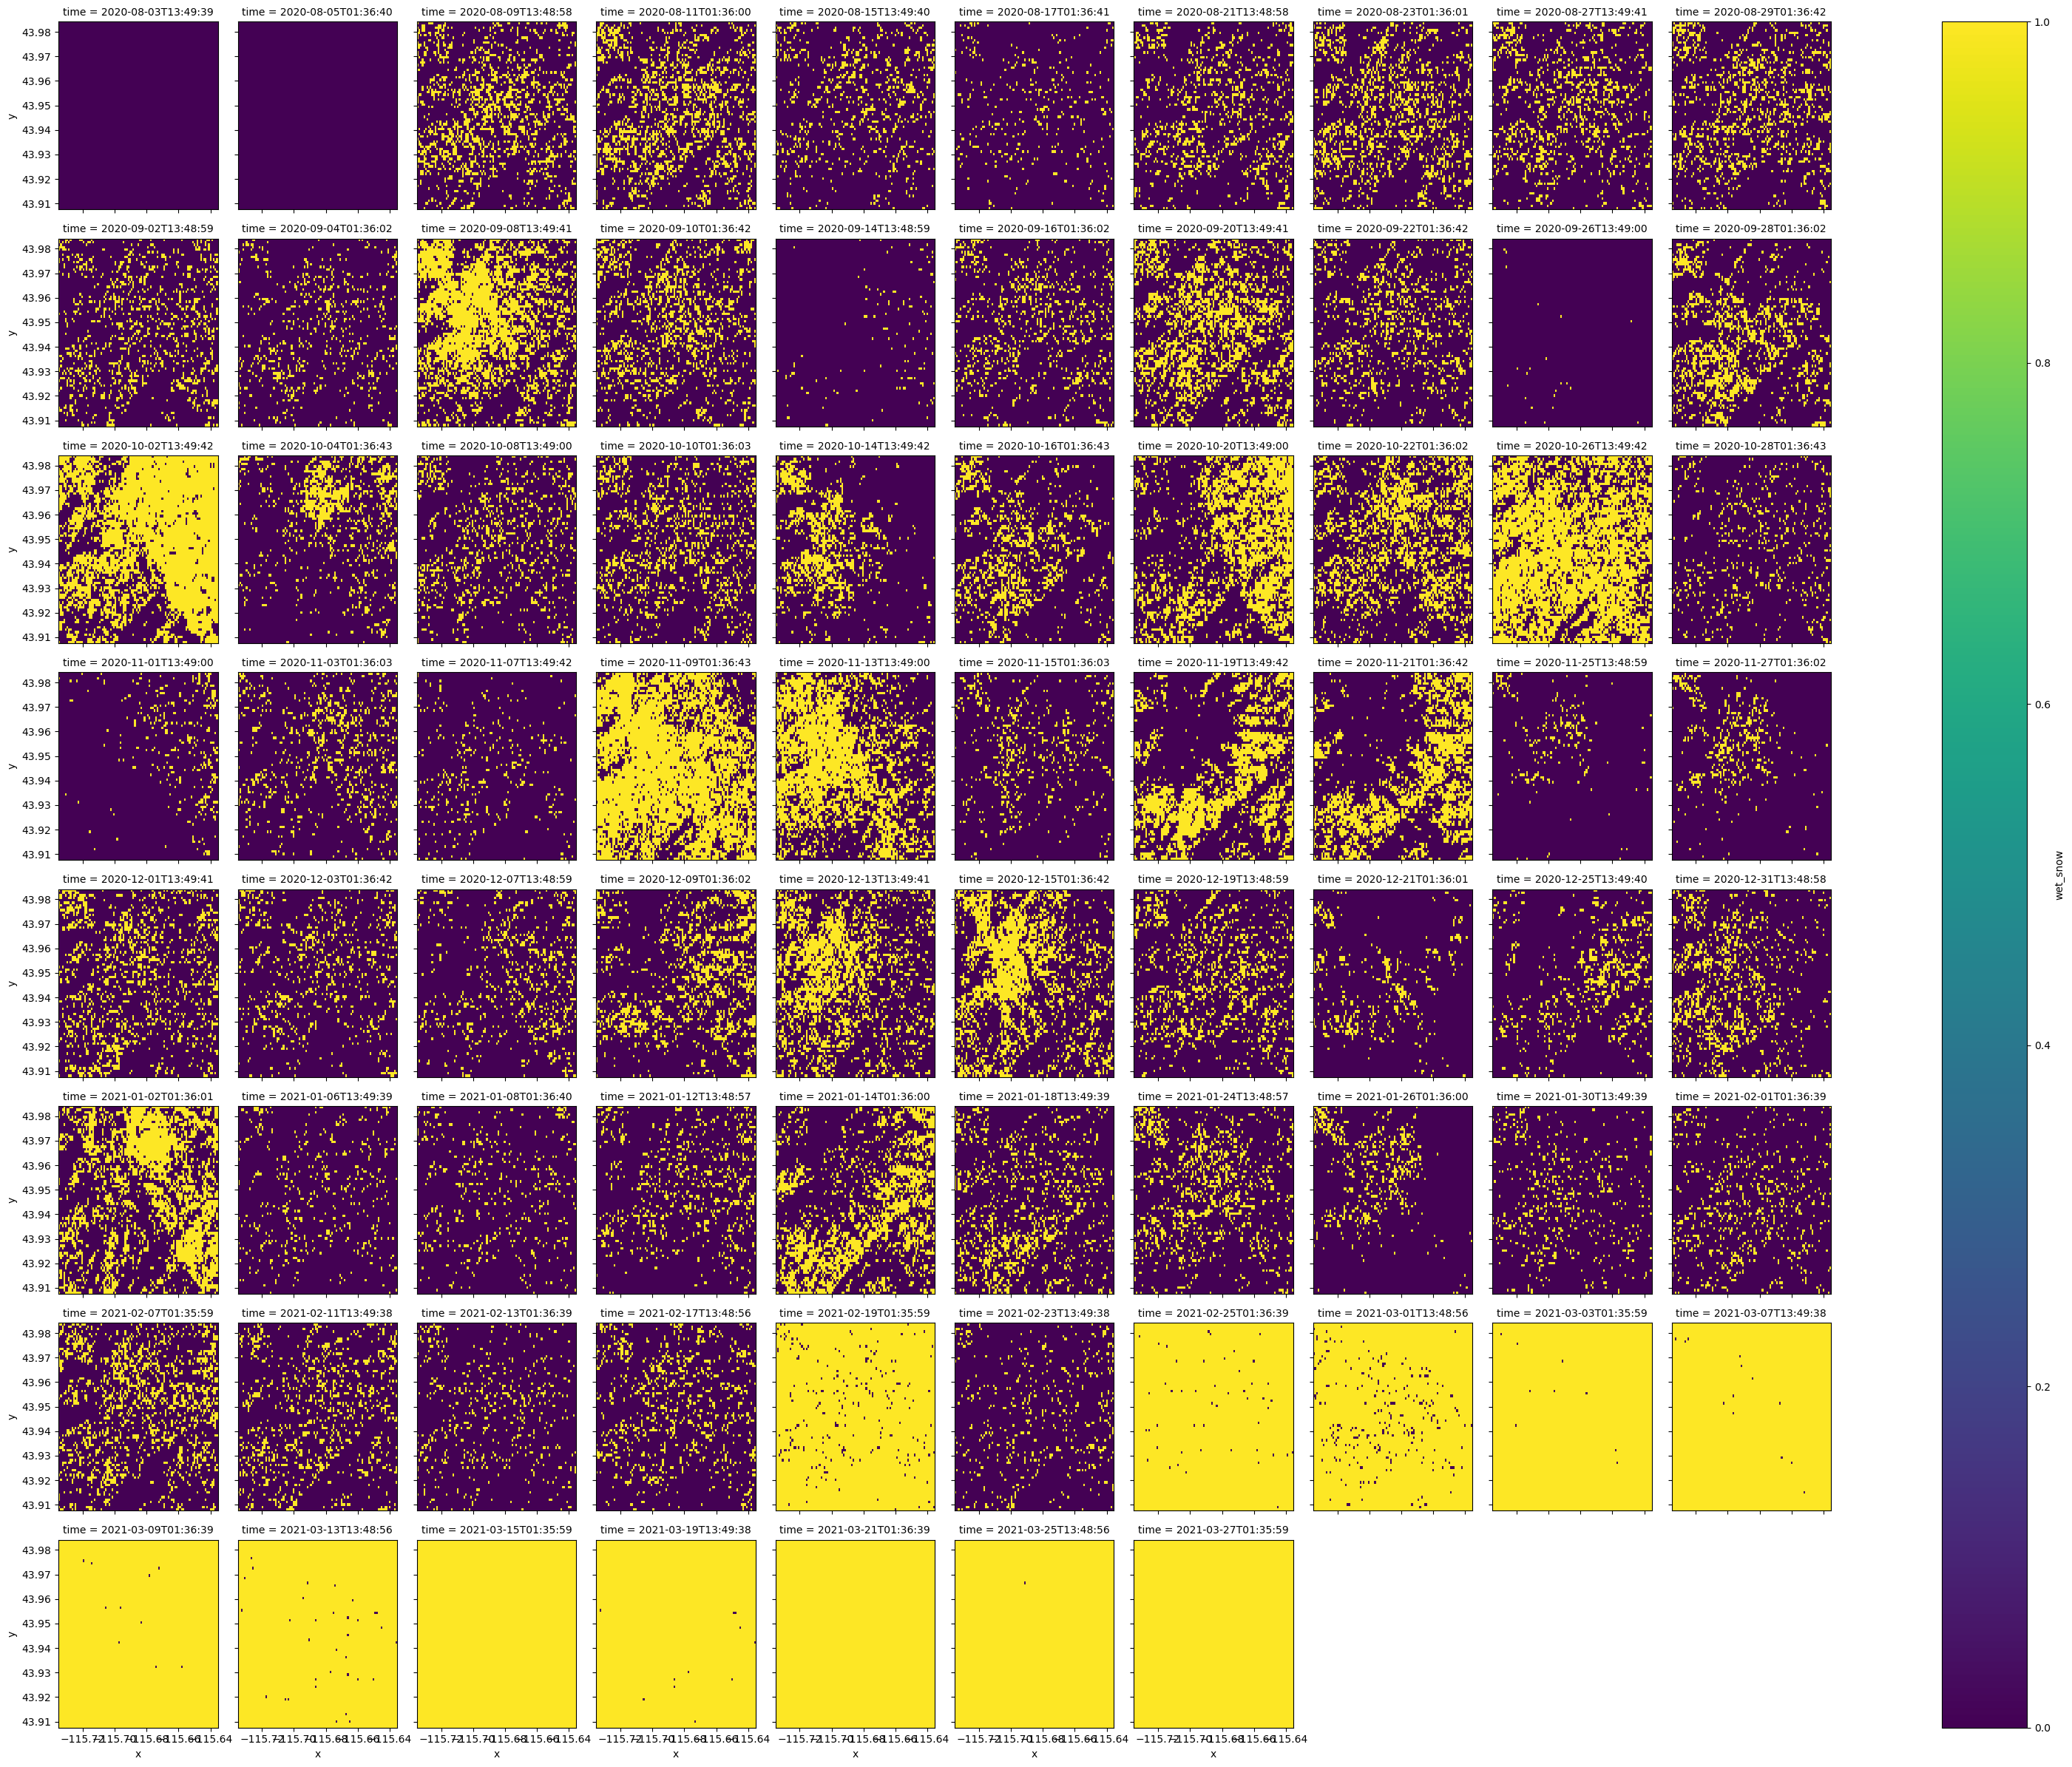

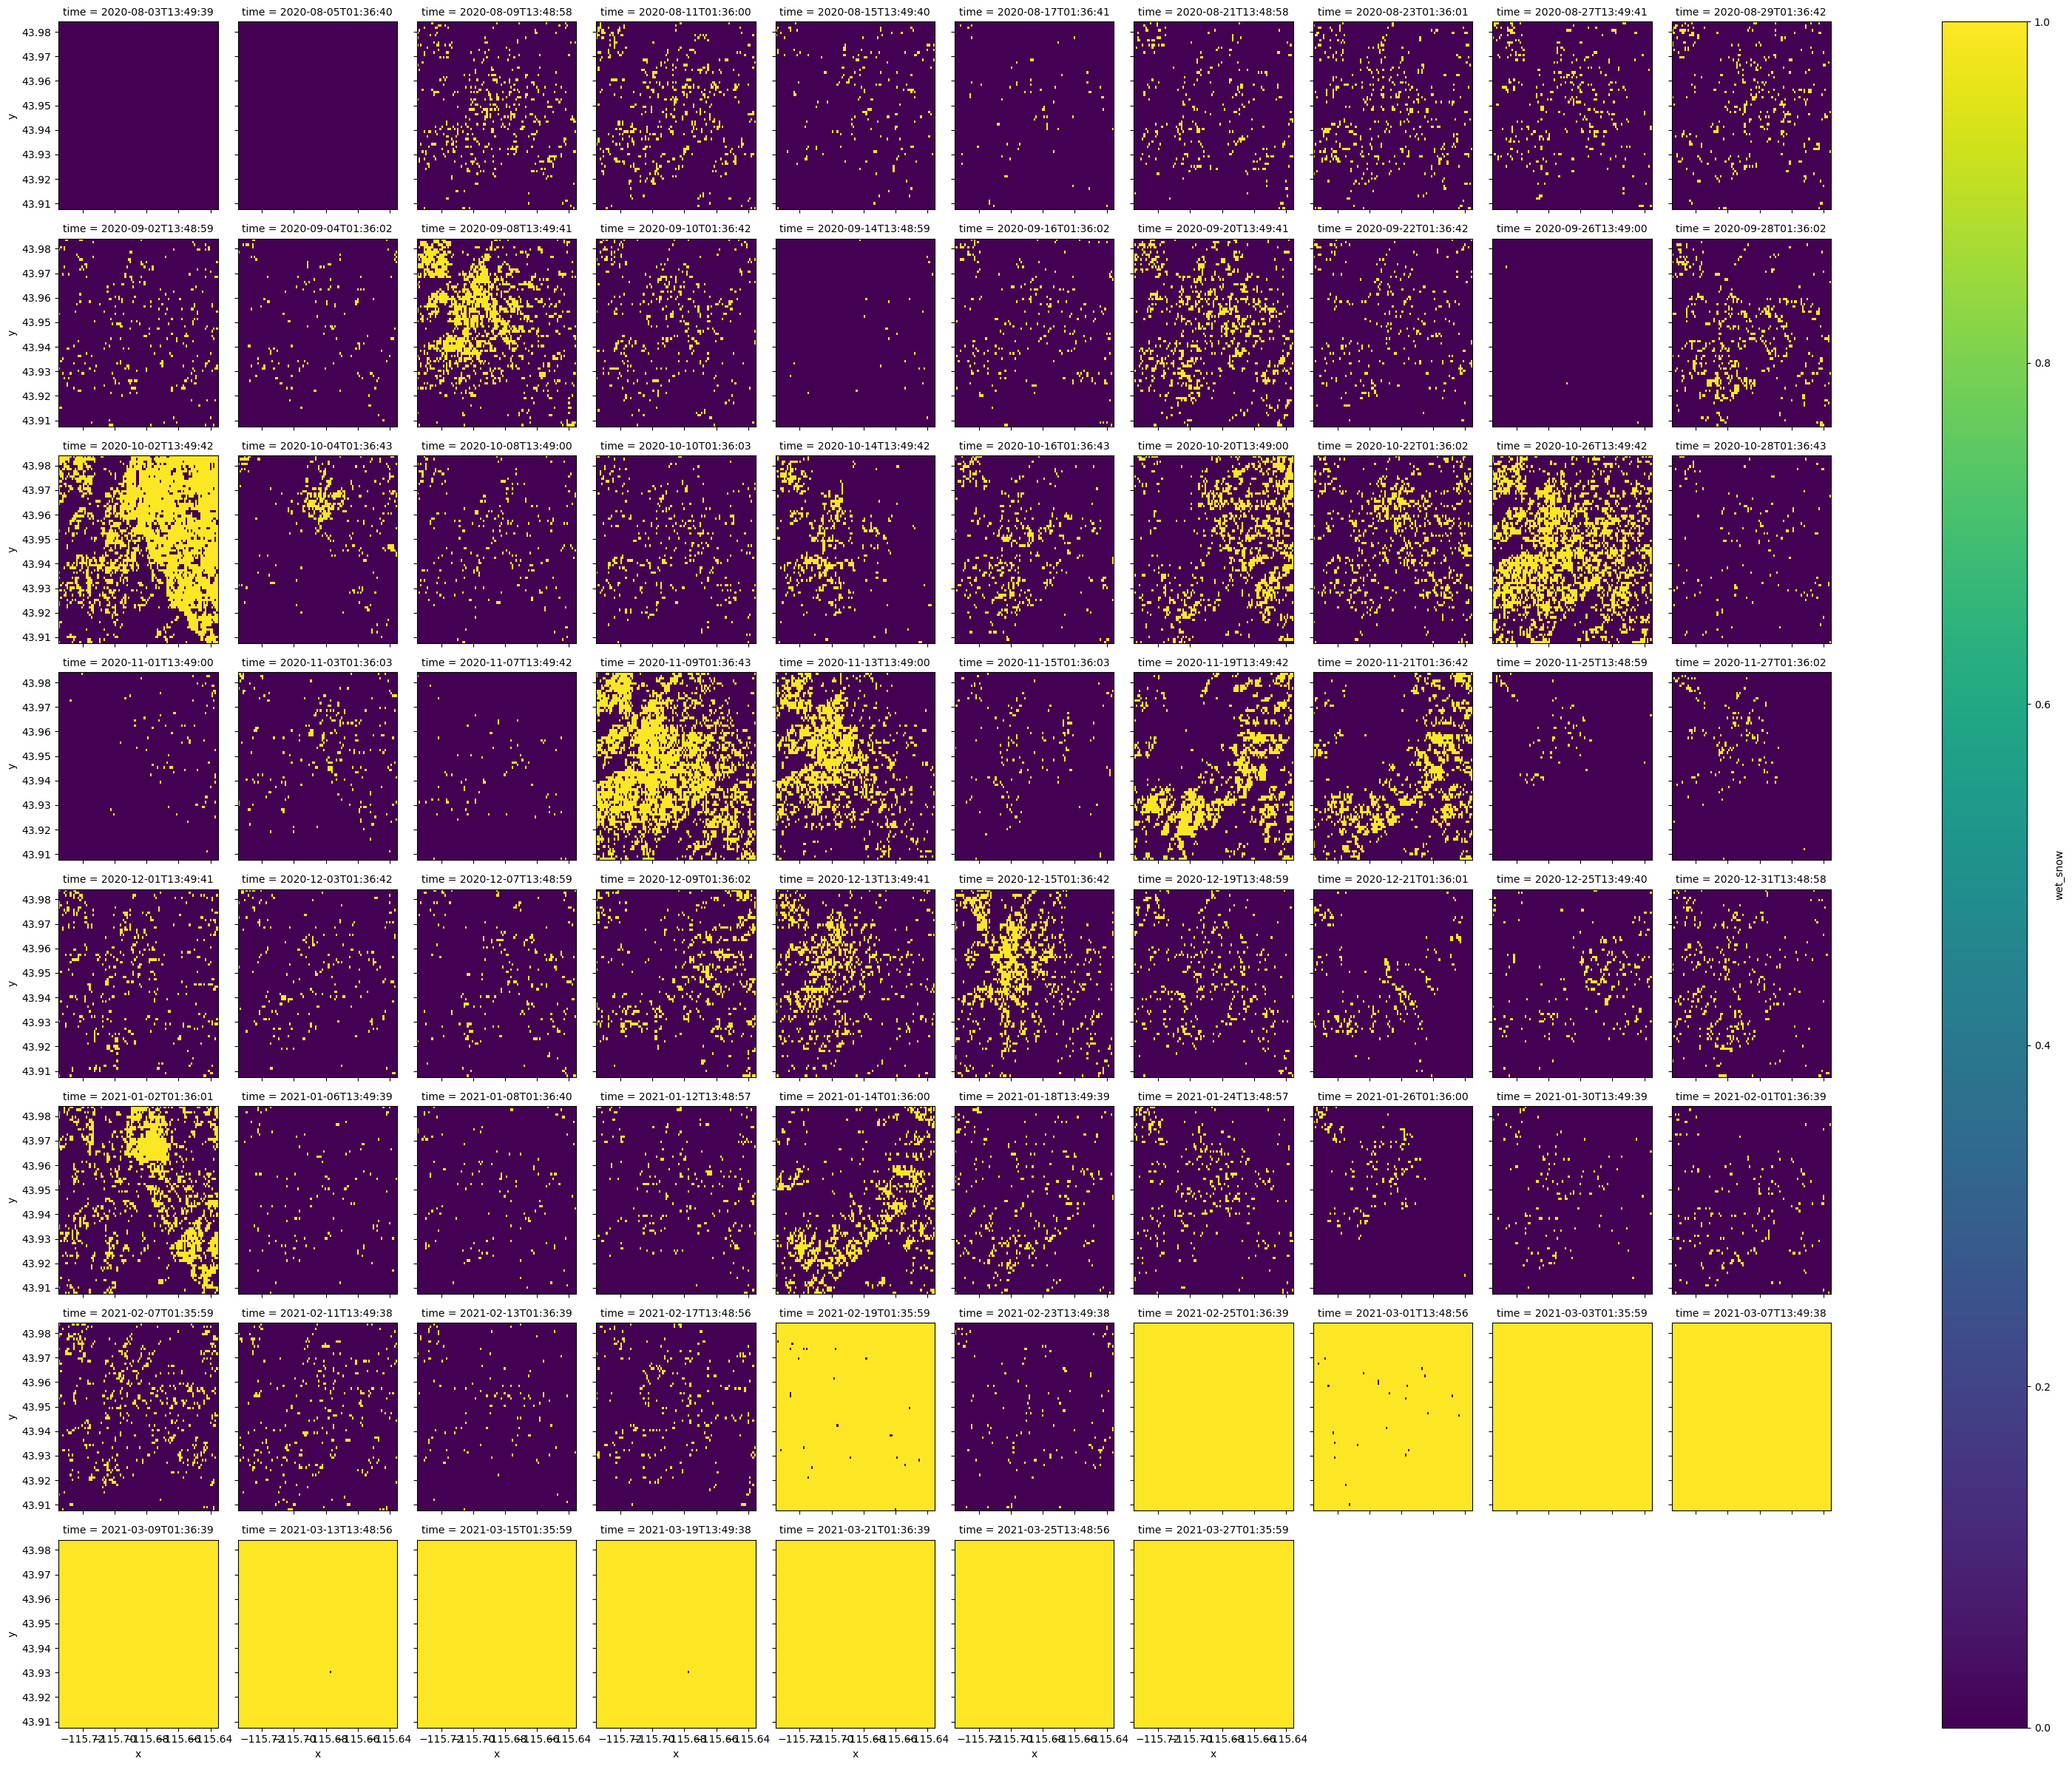

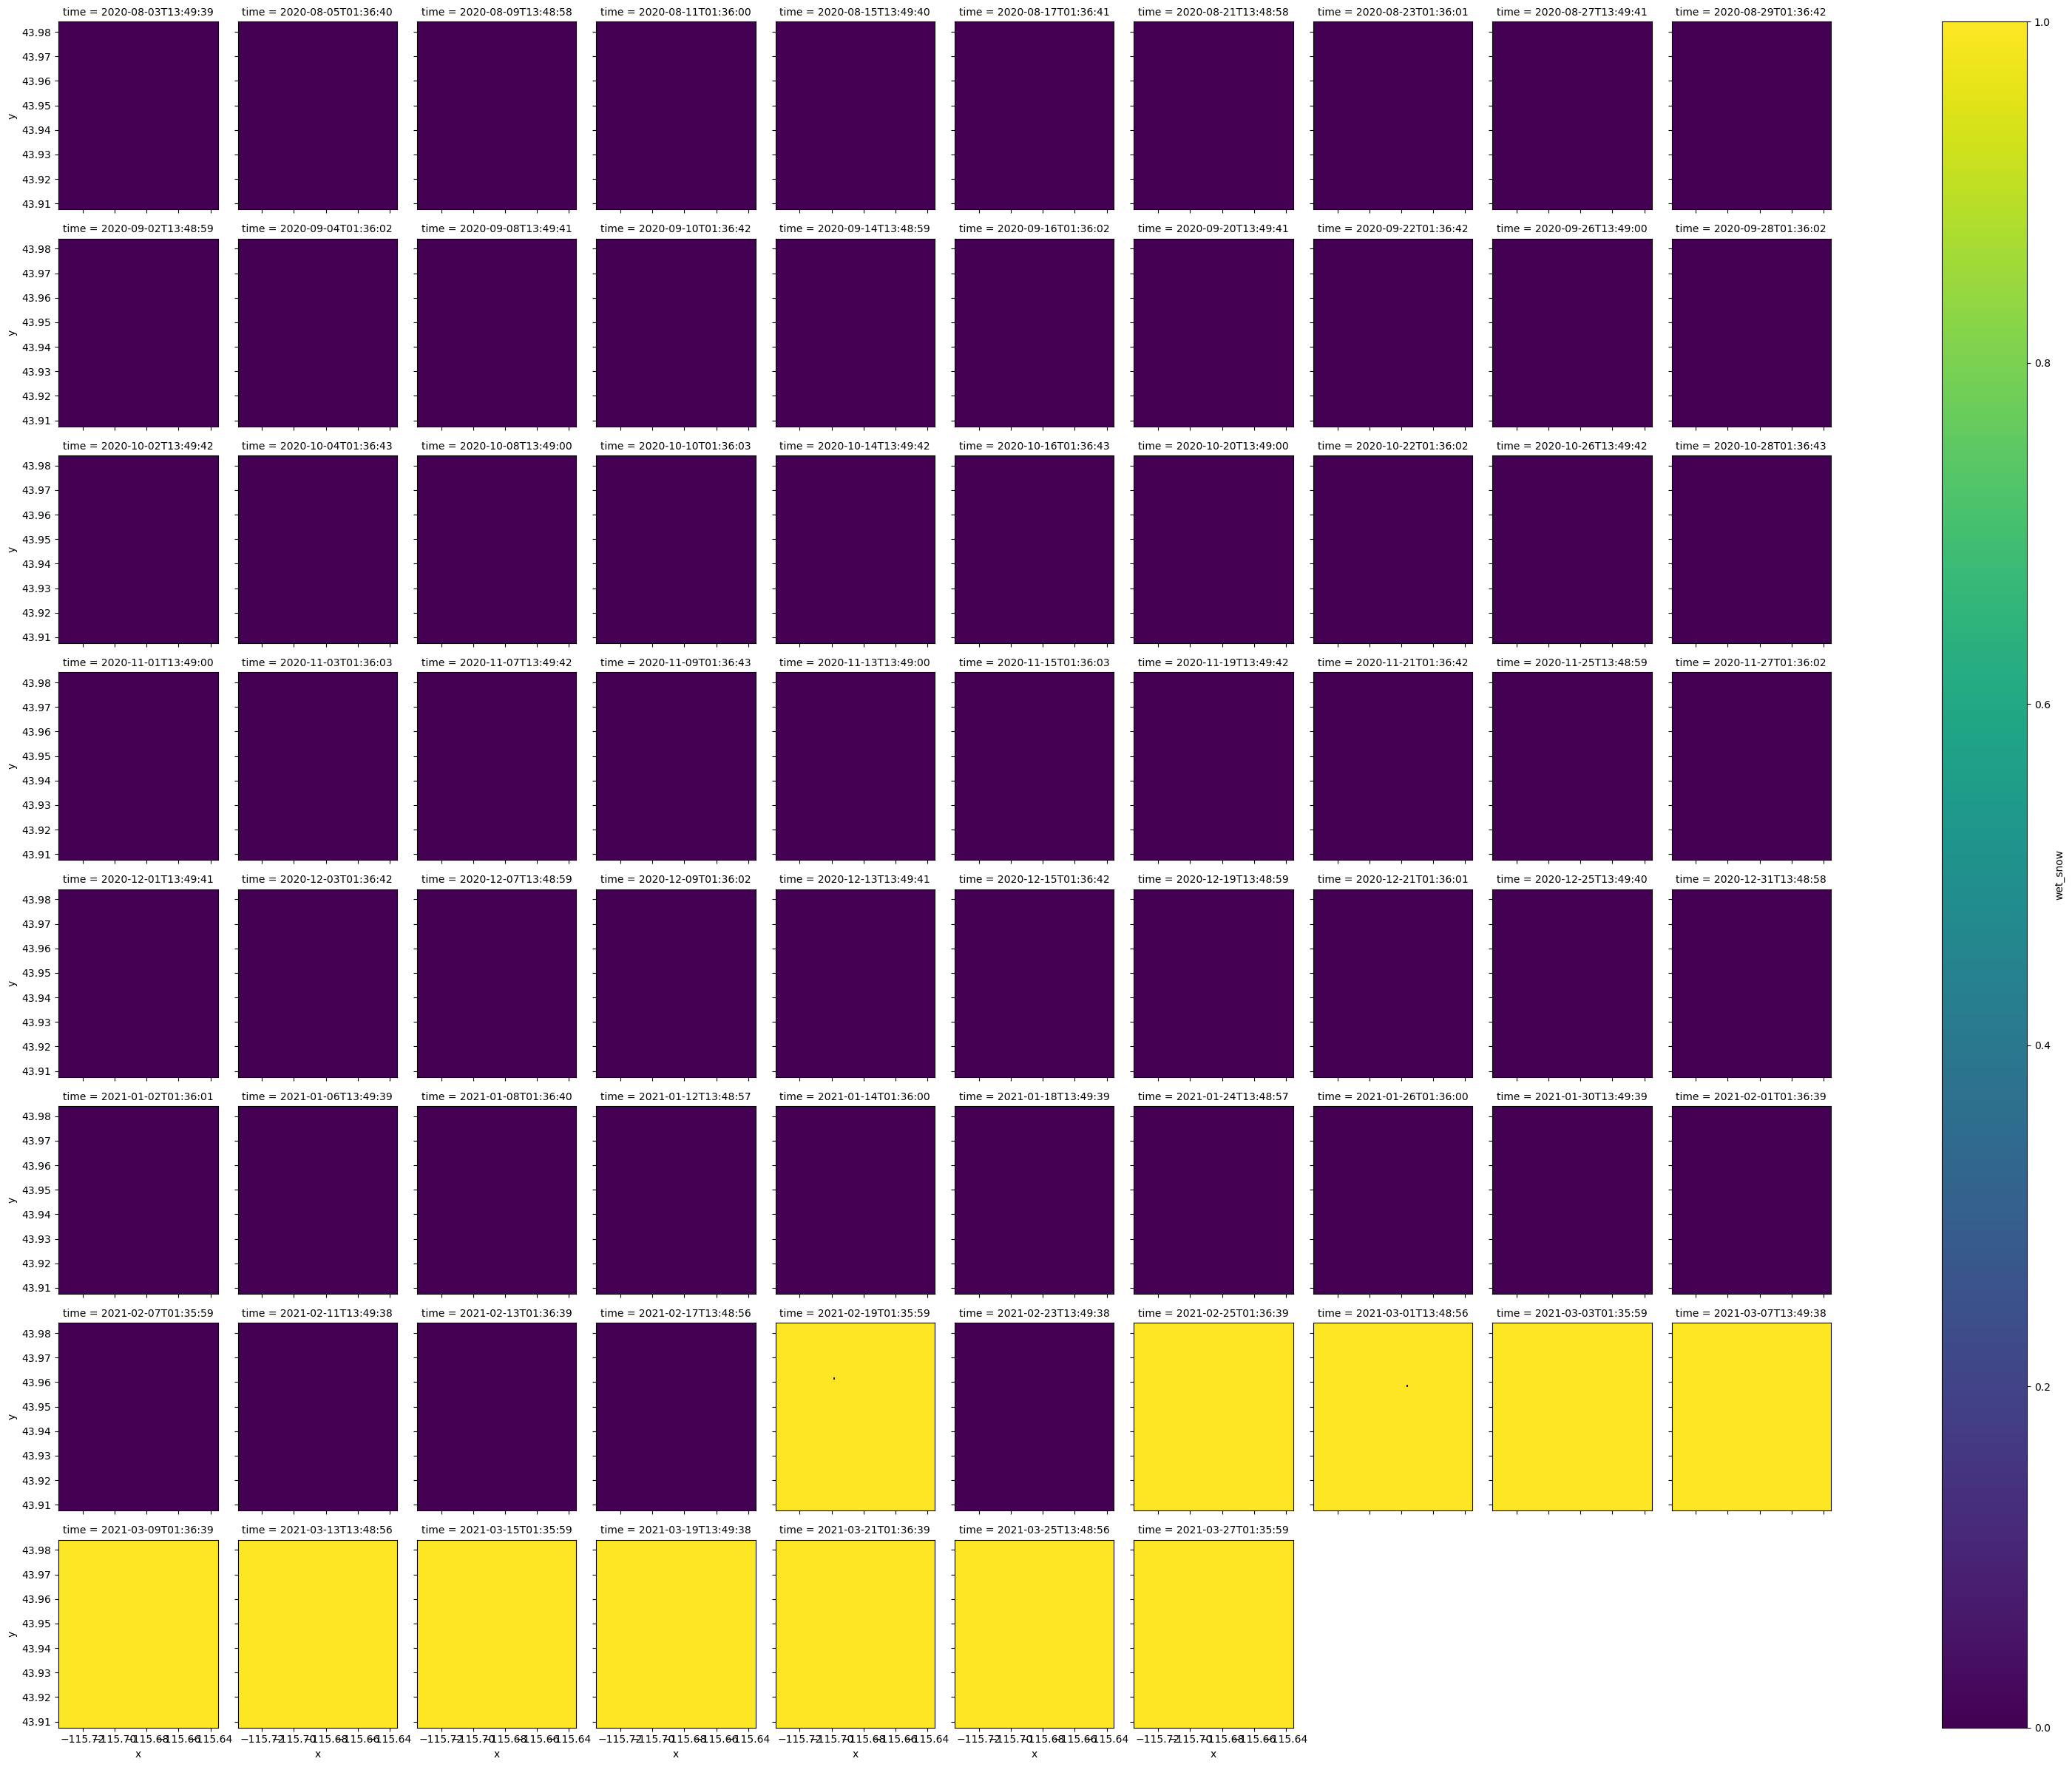

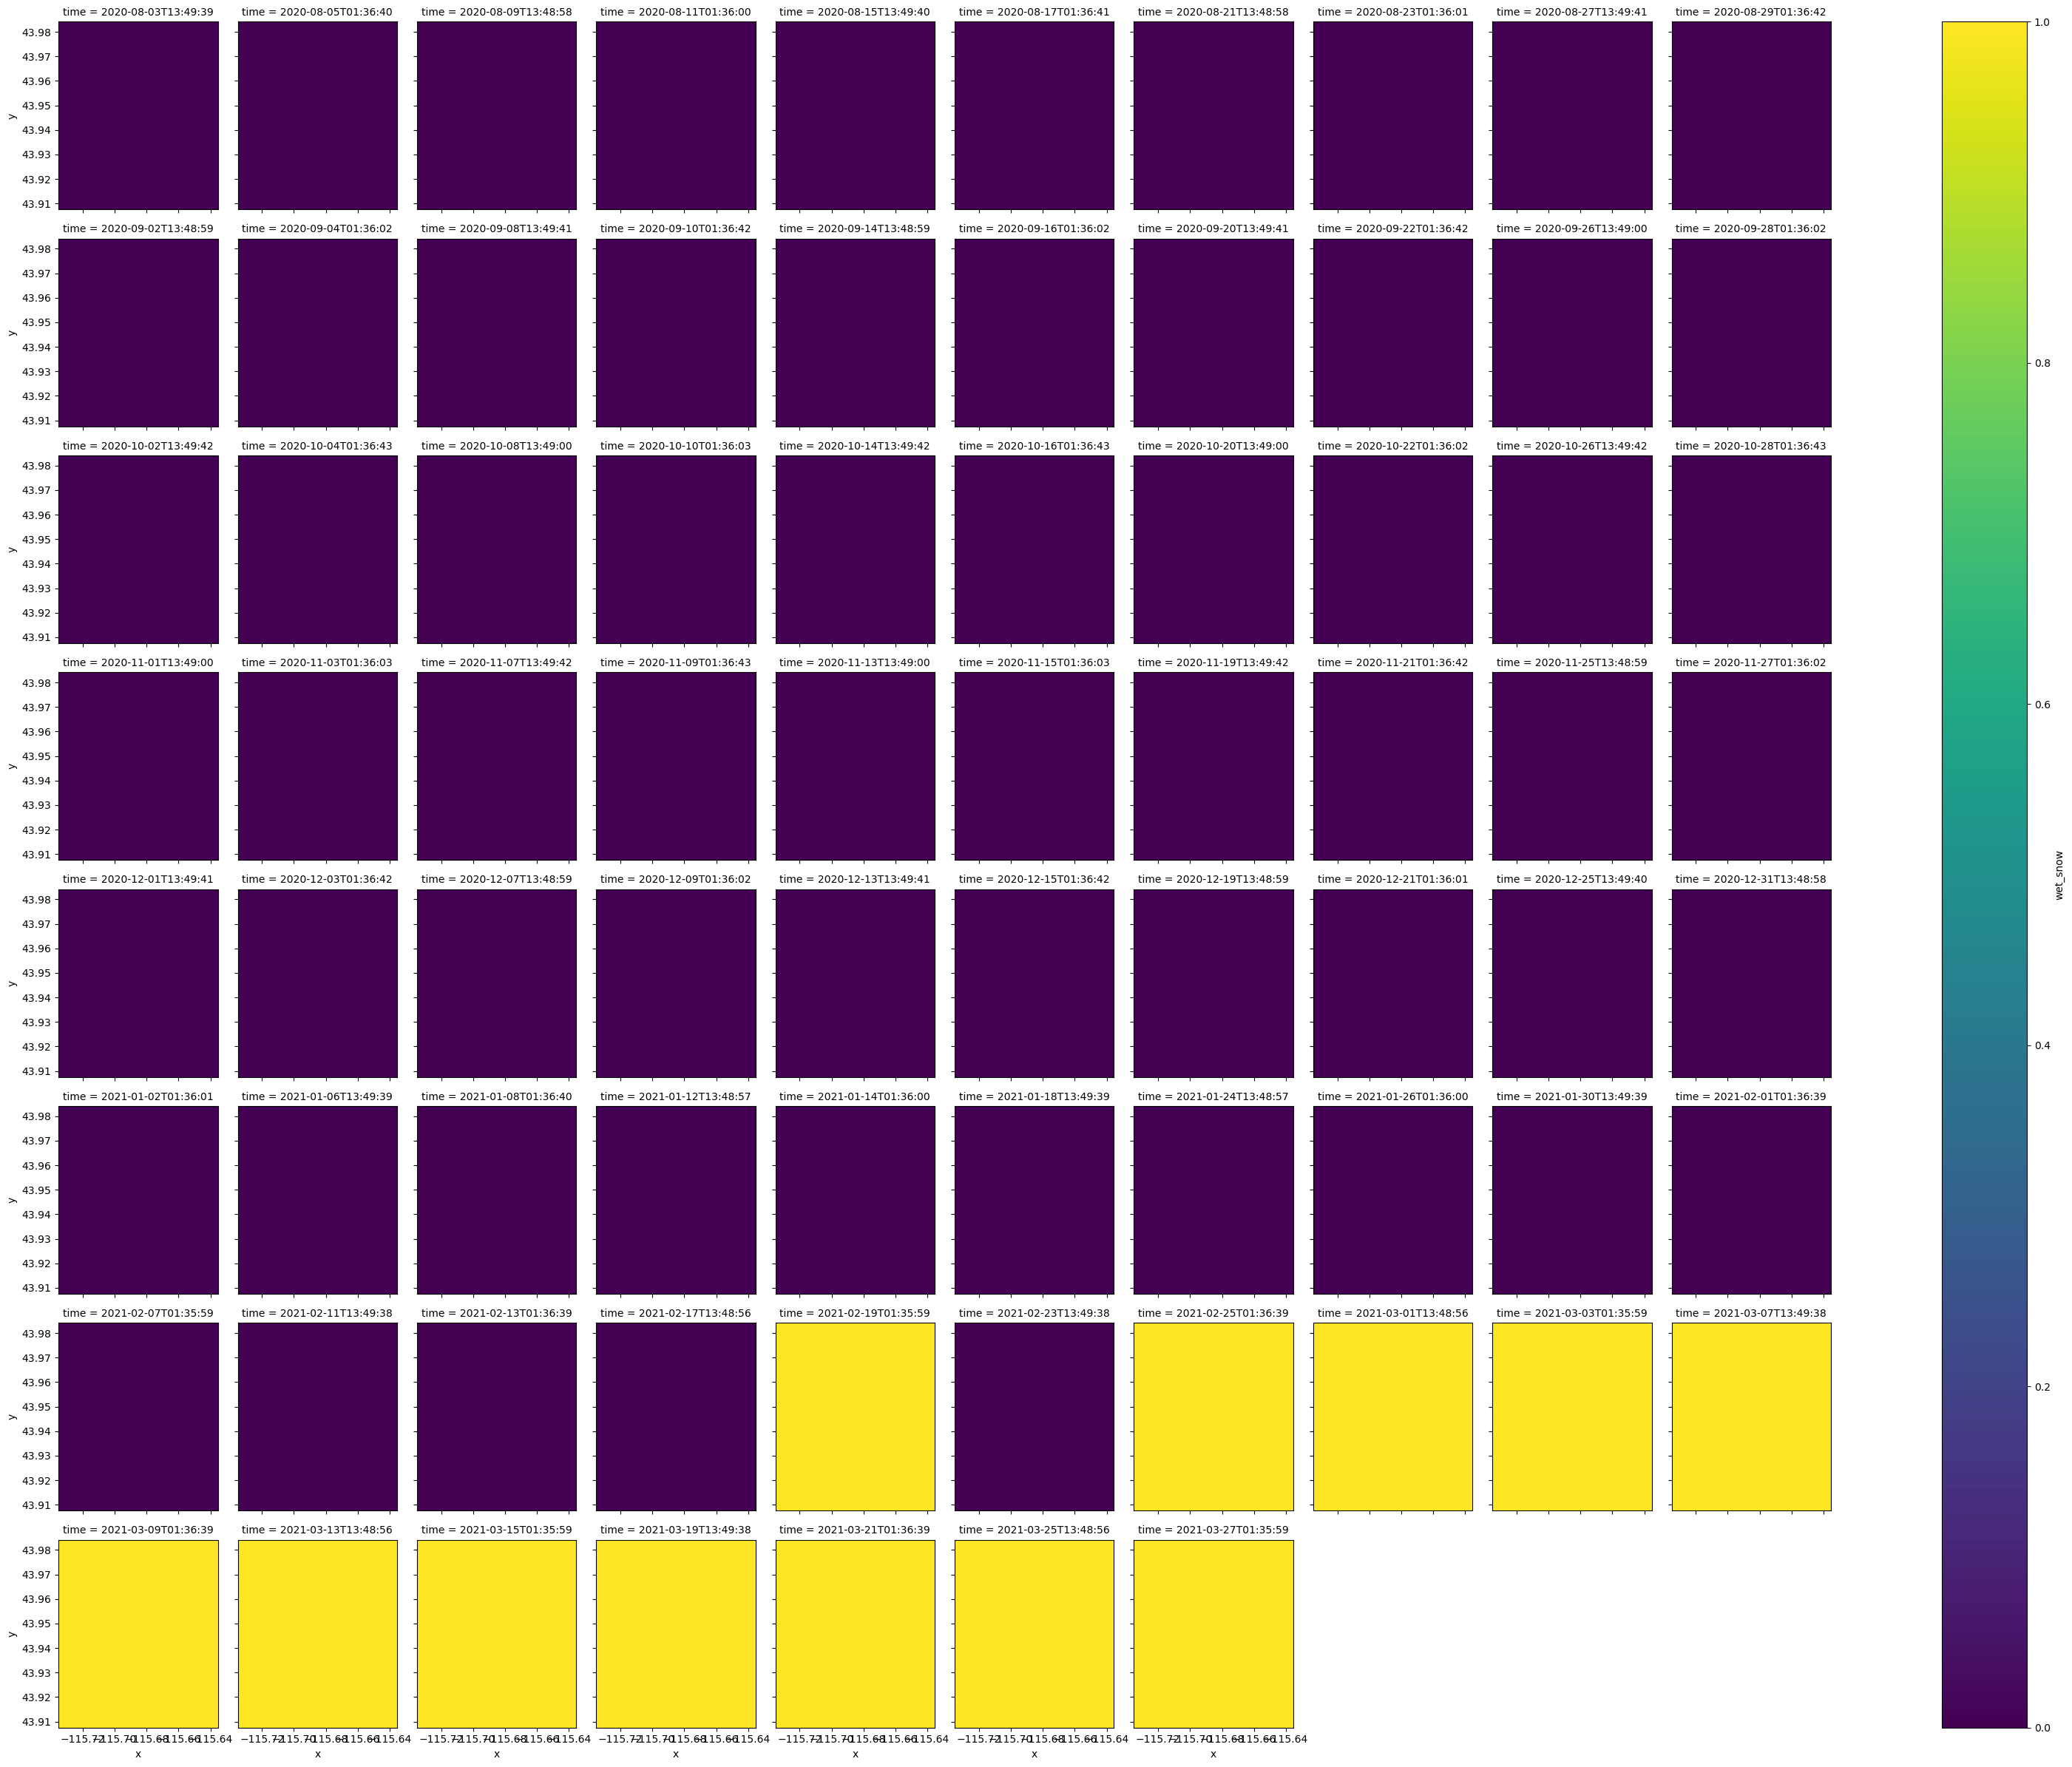

In [14]:
a = 2.5
b = 0.2
c = 0.55
wst = -3

for wst in [-4,-3,-2,-1,0]:
    ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
    ds = calc_delta_gamma(ds, B=b, inplace=False)
    print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
    ds = id_newly_wet_snow(ds,wet_thresh=wst)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
    ds = flag_wet_snow(ds)

    ds['wet_snow'].plot(col='time',col_wrap=10)

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,5))
ds['snow_depth'].sel(time=closest_ts).plot(ax=ax[0])
ds['wet_snow'].sel(time=closest_ts).plot(ax=ax[1])

In [ ]:
a = 2.5
b = 0.2
c = 0.55

for wst in [0,-1,-2,-3,-4,-5,-6,-7,-1000]:
    ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
    ds = calc_delta_gamma(ds, B=b, inplace=False)
    print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
    ds = clip_delta_gamma_outlier(ds,thresh=8)
    ds = calc_snow_index(ds)
    ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
    ds = id_newly_wet_snow(ds,wet_thresh=wst)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
    ds = flag_wet_snow(ds)
    f,ax=plt.subplots(1,2,figsize=(12,5))
    ds['snow_depth'].sel(time=closest_ts).plot(ax=ax[0])
    ds['wet_snow'].sel(time=closest_ts).plot(ax=ax[1])


In [ ]:
mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | ds['wet_snow'].sel(time=closest_ts).astype(bool))
mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))

In [ ]:
ds

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(mask)
mask_wet.plot(ax=ax[1])

In [ ]:
mask.sum()

In [ ]:
mask_wet.sum()

In [ ]:
mask_wet.sum()/mask.sum()

In [ ]:
( mask.sum() - mask_wet.sum()  ) / mask.sum()

In [ ]:
#mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | ds['wet_snow'].sel(time=closest_ts).astype(bool))
#mask_wet.sum()
# f,ax=plt.subplots()
# ax.imshow(mask_wet)
# mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
# mask
# f,ax=plt.subplots()
# ax.imshow(mask)